In [1]:
import os
import random
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) Dataset 정의: 500×500 이미지를 PatchEmbedding 없이 그대로 사용
# ─────────────────────────────────────────────────────────────────────────────
class NoisyImageDataset(Dataset):
    def __init__(self, images, labels, lbl_min, lbl_max):
        """
        images: (N, 500, 500) numpy array, raw pixel values (0~4095)
        labels: (N,) numpy array, raw labels
        lbl_min, lbl_max: 레이블 Min–Max 정규화 상수
        """
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.float32)
        self.lbl_min = lbl_min
        self.lbl_max = lbl_max
        self.to_tensor = T.ToTensor()  # (H, W) → (1, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]   # (500, 500)
        lbl = self.labels[idx]   # float

        # 1) [0,4095] → [0,1]
        img_norm = img / 4095.0

        # 2) Grayscale → Tensor (1, 500, 500)
        img_tensor = self.to_tensor(img_norm)

        # 3) 레이블 Min–Max 정규화 → [-1,1]
        lbl_norm = (lbl - self.lbl_min) / (self.lbl_max - self.lbl_min + 1e-8)  # [0,1]
        lbl_scaled = lbl_norm * 2.0 - 1.0                                       # [-1,1]
        lbl_tensor = torch.tensor(lbl_scaled, dtype=torch.float32)

        return img_tensor, lbl_tensor

# ─────────────────────────────────────────────────────────────────────────────
# 2) ViT 모델 정의: 패치 크기 50, 3 Transformer 블록
# ─────────────────────────────────────────────────────────────────────────────
class ViT50_3block(nn.Module):
    def __init__(self,
                 img_size=500,
                 patch_size=50,
                 embed_dim=256,
                 depth=3,
                 num_heads=8,
                 mlp_dim=512,
                 num_classes=1):
        """
        img_size: 입력 이미지 해상도 (여기서는 500×500)
        patch_size: 각 패치 크기 (50×50)
        embed_dim: 패치 임베딩 차원(여기선 256)
        depth: Transformer Encoder 레이어 개수 (3개)
        num_heads: 멀티헤드 어텐션 헤드 수 (8개)
        mlp_dim: Transformer 내부 MLP 숨겨진 차원 (512)
        num_classes: 출력 노드 수 (회귀용이므로 1)
        """
        super().__init__()
        assert img_size % patch_size == 0, "Image size must be divisible by patch size."
        num_patches = (img_size // patch_size) ** 2  # (500/50)² = 10×10 = 100

        # 2-1) Patch Embedding: Conv2d(1→embed_dim, kernel=patch_size, stride=patch_size)
        self.patch_embed = nn.Conv2d(
            in_channels=1,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        # 결과: (B, embed_dim, 10, 10)

        # 2-2) Class Token 학습 파라미터
        #   (시퀀스 앞에 붙일 학습 가능한 토큰, shape=(1,1,embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # 2-3) Positional Embedding: (1, num_patches+1, embed_dim)
        #   시퀀스 길이 = 패치 수(100) + cls 토큰(1) = 101
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # 2-4) Transformer Encoder: 3개의 레이어 (nn.TransformerEncoderLayer 반복)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=mlp_dim,
            dropout=0.0,
            activation='gelu',
            batch_first=False  # (seq_len, batch, embed_dim) 입력을 기대
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # 2-5) 회귀용 Head: Transformer 마지막 CLS 출력(256차원) → Linear(256→1)
        self.head = nn.Linear(embed_dim, num_classes)

        # 2-6) 파라미터 초기화
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        """
        x: (B, 1, 500, 500)
        """
        B = x.size(0)

        # (1) Patch Embedding
        #    입력 (B,1,500,500) → Conv2d → (B, embed_dim, 10, 10)
        x = self.patch_embed(x)

        # (2) Flatten & Transpose
        #    (B, embed_dim, 10, 10) → (B, embed_dim, 100) → (B, 100, embed_dim)
        x = x.flatten(2).transpose(1, 2)

        # (3) CLS 토큰 결합
        #    cls_token (1,1,embed_dim) → expand → (B,1,embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        #    (B,1,embed_dim) + (B,100,embed_dim) → (B,101,embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)

        # (4) Positional Embedding 추가
        #    pos_embed (1,101,embed_dim) → 브로드캐스트 → (B,101,embed_dim)
        x = x + self.pos_embed

        # (5) Transformer 인코더 expects (seq_len, batch, embed_dim)
        x = x.transpose(0, 1)  # (101, B, embed_dim)
        x = self.transformer(x)  # (101, B, embed_dim)

        # (6) CLS 토큰 출력만 사용: x[0] → (B, embed_dim)
        cls_out = x[0]

        # (7) 회귀 Head: (B, embed_dim) → (B, 1) → squeeze → (B,)
        out = self.head(cls_out).squeeze(-1)
        return out

# ─────────────────────────────────────────────────────────────────────────────
# 3) train_validate 함수: Early Stopping + ReduceLROnPlateau + AdamW
# ─────────────────────────────────────────────────────────────────────────────
def train_validate(model, train_loader, val_loader, criterion, optimizer, scheduler,
                   num_epochs=100, patience=10, save_path='./best_vit50_3block.pth'):
    device = next(model.parameters()).device
    best_val_loss = float('inf')
    wait = 0

    for epoch in range(1, num_epochs + 1):
        # ─── Training ─────────────────────────────────────────────────────
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)   # (B, 1, 500, 500)
            labels = labels.to(device)   # (B,)

            optimizer.zero_grad()
            outputs = model(images)      # (B,)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)

        # ─── Validation ───────────────────────────────────────────────────
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        val_loss   = running_val_loss   / len(val_loader.dataset)
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {lr:.6g}")

        # ─── ReduceLROnPlateau 스케줄러 업데이트 ─────────────────────────────
        #    scheduler.step(val_loss) → val_loss 기반으로 LR 감소
        scheduler.step(val_loss)

        # ─── Early Stopping 및 Best Model 저장 ─────────────────────────────
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            torch.save(model.state_dict(), save_path)
            print(f"  → New best val loss: {best_val_loss:.6f}, saved to {save_path}")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    return model

Train: 12000, Val: 1500, Test: 1500


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch   1 | Train Loss: 0.114494 | Val Loss: 0.000540 | LR: 0.0001
  → New best val loss: 0.000540, saved to ./copy_7.pth
Epoch   2 | Train Loss: 0.000606 | Val Loss: 0.000398 | LR: 0.0001
  → New best val loss: 0.000398, saved to ./copy_7.pth
Epoch   3 | Train Loss: 0.000512 | Val Loss: 0.001727 | LR: 0.0001
Epoch   4 | Train Loss: 0.000774 | Val Loss: 0.000810 | LR: 0.0001
Epoch   5 | Train Loss: 0.000486 | Val Loss: 0.000321 | LR: 0.0001
  → New best val loss: 0.000321, saved to ./copy_7.pth
Epoch   6 | Train Loss: 0.000382 | Val Loss: 0.000285 | LR: 0.0001
  → New best val loss: 0.000285, saved to ./copy_7.pth
Epoch   7 | Train Loss: 0.000417 | Val Loss: 0.000500 | LR: 0.0001
Epoch   8 | Train Loss: 0.000310 | Val Loss: 0.000158 | LR: 0.0001
  → New best val loss: 0.000158, saved to ./copy_7.pth
Epoch   9 | Train Loss: 0.000288 | Val Loss: 0.000266 | LR: 0.0001
Epoch  10 | Train Loss: 0.000223 | Val Loss: 0.000122 | LR: 0.0001
  → New best val loss: 0.000122, saved to ./copy_7.pth


/tmp/ipykernel_248103/1141556380.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


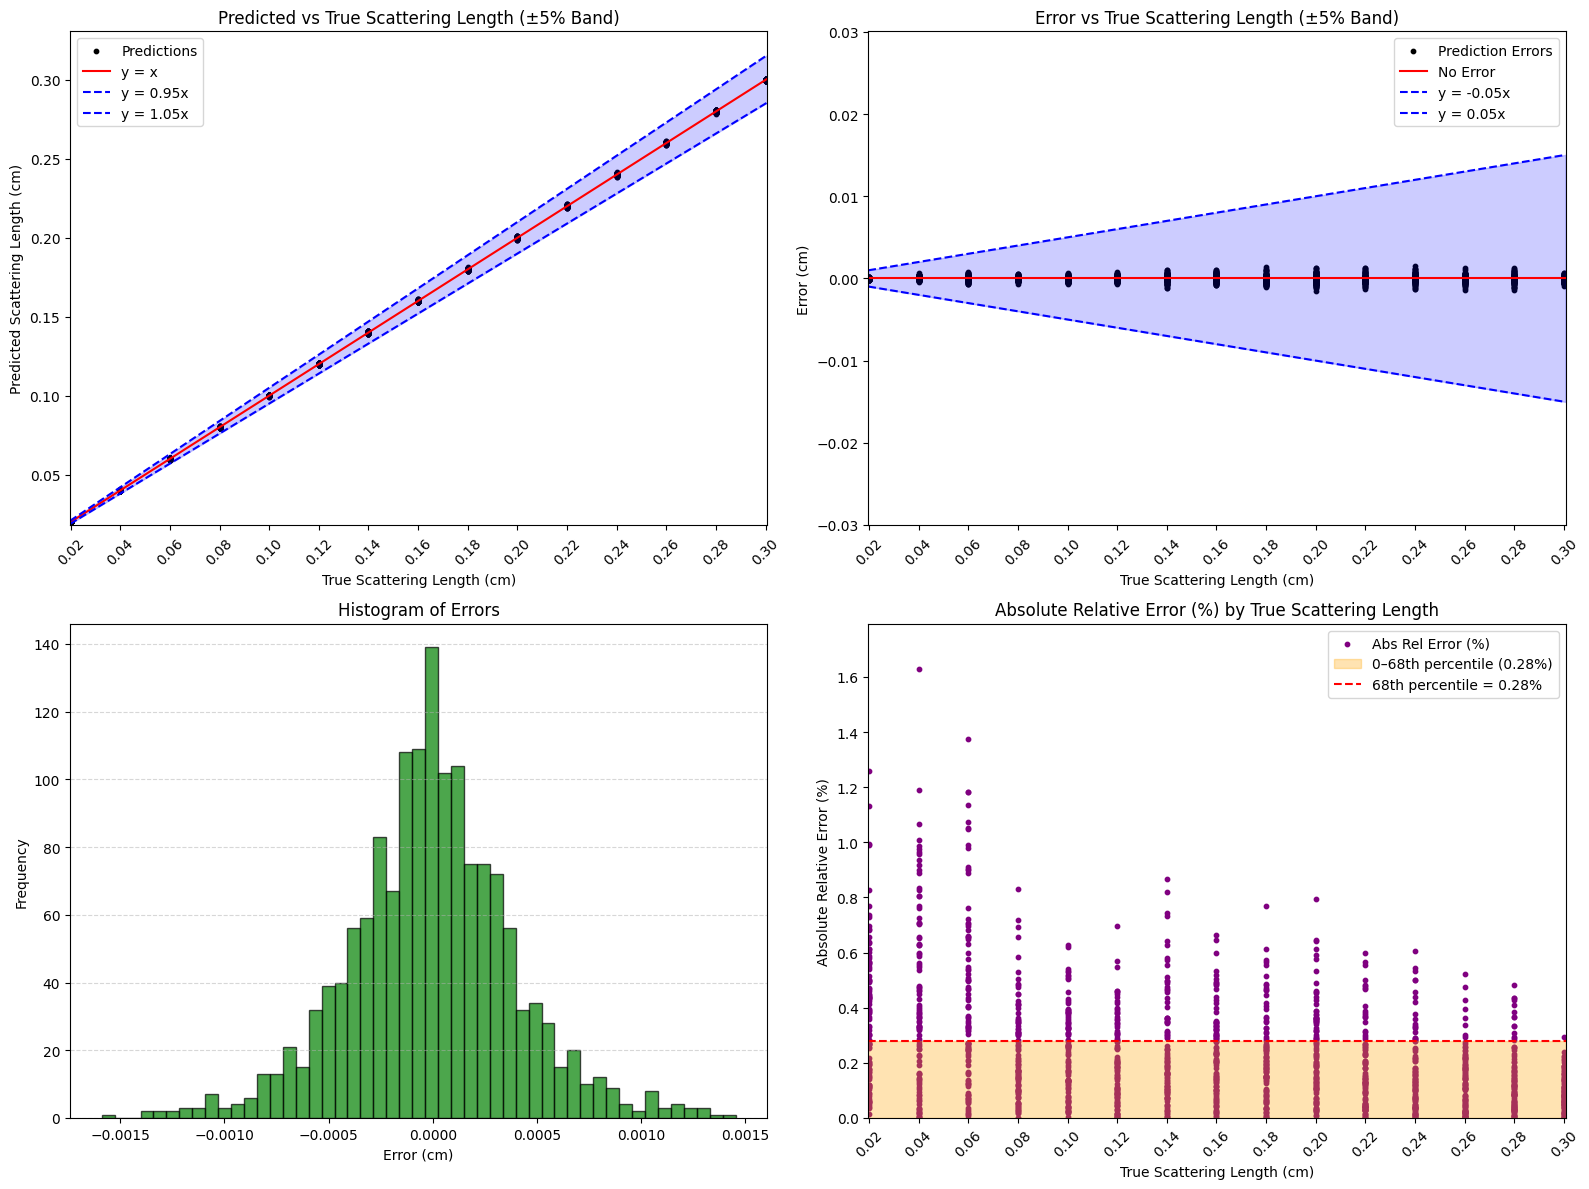

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# 4) 전체 파이프라인: 데이터 로드 → DataLoader → 모델 정의 → 학습 → 평가 → 시각화
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == '__main__':
    seed = 14000
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # DataLoader용 worker 시드 고정 함수
    def seed_worker(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(seed)
    train_h5 = '/home/work/CamSim/Hole_Output/s2_best_initialtraining/train_dataset.h5'
    val_h5   = '/home/work/CamSim/Hole_Output/s2_best_initialtraining/val_dataset.h5'
    test_h5  = '/home/work/CamSim/Hole_Output/s2_best_initialtraining/test_dataset.h5'

    # (B) 전체 레이블을 기준으로 Min/Max 계산
    all_labels = []
    for path in [train_h5, val_h5, test_h5]:
        with h5py.File(path, 'r') as f:
            all_labels.append(f['labels'][:])
    all_labels = np.concatenate(all_labels)
    lbl_min = all_labels.min()
    lbl_max = all_labels.max()

    # (C) 데이터셋 생성
    def load_dataset(path, lbl_min, lbl_max):
        with h5py.File(path, 'r') as f:
            images = f['images'][:]
            labels = f['labels'][:]
        return NoisyImageDataset(images, labels, lbl_min, lbl_max)

    train_dataset = load_dataset(train_h5, lbl_min, lbl_max)
    val_dataset   = load_dataset(val_h5,   lbl_min, lbl_max)
    test_dataset  = load_dataset(test_h5,  lbl_min, lbl_max)

    # (D) DataLoader 생성
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                            num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                            num_workers=4, pin_memory=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                            num_workers=4, pin_memory=True)

    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # (C) 모델 정의: ViT50_3block
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ViT50_3block(
        img_size=500,
        patch_size=50,
        embed_dim=256,
        depth=3,
        num_heads=8,
        mlp_dim=1024,
        num_classes=1
    ).to(device)

    # (D) Optimizer & Scheduler: AdamW + ReduceLROnPlateau
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer,
                                  mode='min',
                                  factor=0.7,
                                  patience=2,
                                  verbose=True)

    # (E) 모델 학습
    best_model_path = './copy_7.pth'
    model = train_validate(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        num_epochs=300,
        patience=11,
        save_path=best_model_path
    )

    # (F) 테스트 세트 평가
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    true_vals = []
    pred_vals = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)   # (B, 1, 500, 500)
            labels = labels.to(device)   # (B,)
            outputs = model(images)      # (B,)

            # 정규화 복원 → 원래 스케일로
            labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
            preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

            true_vals.extend(labels_orig.tolist())
            pred_vals.extend(preds_orig.tolist())

    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    errors = pred_vals - true_vals
    abs_rel_errors = np.abs(errors / true_vals) * 100.0

    # (G) 결과 시각화
    plt.figure(figsize=(16, 12))
    mn = min(true_vals.min(), pred_vals.min())
    mx = max(true_vals.max(), pred_vals.max())
    unique_true_labels = np.unique(true_vals)

    # 1) Predicted vs True with ±5% Band
    ax1 = plt.subplot(2, 2, 1)
    ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
    ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
    ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
    ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
    ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
    ax1.set_xticks(unique_true_labels)
    ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
    ax1.set_xlabel("True Scattering Length (cm)")
    ax1.set_ylabel("Predicted Scattering Length (cm)")
    ax1.set_xlim(mn, mx)
    ax1.set_ylim(mn * 0.9, mx * 1.1)
    ax1.legend()

    # 2) Error vs True with ±5% Band
    ax2 = plt.subplot(2, 2, 2)
    ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
    ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
    ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
    ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
    ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
    ax2.set_xticks(unique_true_labels)
    ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax2.set_title("Error vs True Scattering Length (±5% Band)")
    ax2.set_xlabel("True Scattering Length (cm)")
    ax2.set_ylabel("Error (cm)")
    ax2.set_xlim(mn, mx)
    ax2.set_ylim(-0.1 * mx, 0.1 * mx)
    ax2.legend()

    # 3) Histogram of Errors (50 bins)
    ax3 = plt.subplot(2, 2, 3)
    bins = np.linspace(errors.min(), errors.max(), 50)
    ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
    ax3.set_title("Histogram of Errors")
    ax3.set_xlabel("Error (cm)")
    ax3.set_ylabel("Frequency")
    ax3.grid(axis='y', linestyle='--', alpha=0.5)

    # 4) Absolute Relative Error (%) by True with 68th Percentile
    ax4 = plt.subplot(2, 2, 4)
    ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
    perc68 = np.percentile(abs_rel_errors, 68)
    ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                     label=f'0–68th percentile ({perc68:.2f}%)')
    ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
               label=f'68th percentile = {perc68:.2f}%')
    ax4.set_xticks(unique_true_labels)
    ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
    ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
    ax4.set_xlabel("True Scattering Length (cm)")
    ax4.set_ylabel("Absolute Relative Error (%)")
    ax4.set_xlim(mn, mx)
    ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
    ax4.legend()

    plt.tight_layout()
    plt.show()

In [4]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    # Training
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
    train_loss = running_train_loss / len(train_loader.dataset)
    val_loss   = running_val_loss   / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch}/{total_epochs}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트 (종류별로 step 방식 맞추기)
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        if wait >= patience:
            print(f"  → Early stopping at epoch {epoch}.")
            break

# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('.pth', '_0.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

Loaded model weights (state_dict only).


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_248103/1399912378.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

[Epoch 1/150] Train Loss: 0.000007 | Val Loss: 0.000012 | LR: 1e-05
  → Improved val loss. Checkpoint updated at epoch 1.
[Epoch 2/150] Train Loss: 0.000007 | Val Loss: 0.000011 | LR: 1e-05
  → Improved val loss. Checkpoint updated at epoch 2.
[Epoch 3/150] Train Loss: 0.000006 | Val Loss: 0.000012 | LR: 1e-05
[Epoch 4/150] Train Loss: 0.000006 | Val Loss: 0.000015 | LR: 1e-05
[Epoch 5/150] Train Loss: 0.000006 | Val Loss: 0.000010 | LR: 1e-05
  → Improved val loss. Checkpoint updated at epoch 5.
[Epoch 6/150] Train Loss: 0.000007 | Val Loss: 0.000020 | LR: 1e-05
[Epoch 7/150] Train Loss: 0.000006 | Val Loss: 0.000011 | LR: 1e-05
[Epoch 8/150] Train Loss: 0.000006 | Val Loss: 0.000013 | LR: 1e-05
[Epoch 9/150] Train Loss: 0.000004 | Val Loss: 0.000009 | LR: 5e-06
  → Improved val loss. Checkpoint updated at epoch 9.
[Epoch 10/150] Train Loss: 0.000004 | Val Loss: 0.000010 | LR: 5e-06
[Epoch 11/150] Train Loss: 0.000004 | Val Loss: 0.000009 | LR: 5e-06
[Epoch 12/150] Train Loss: 0.00000

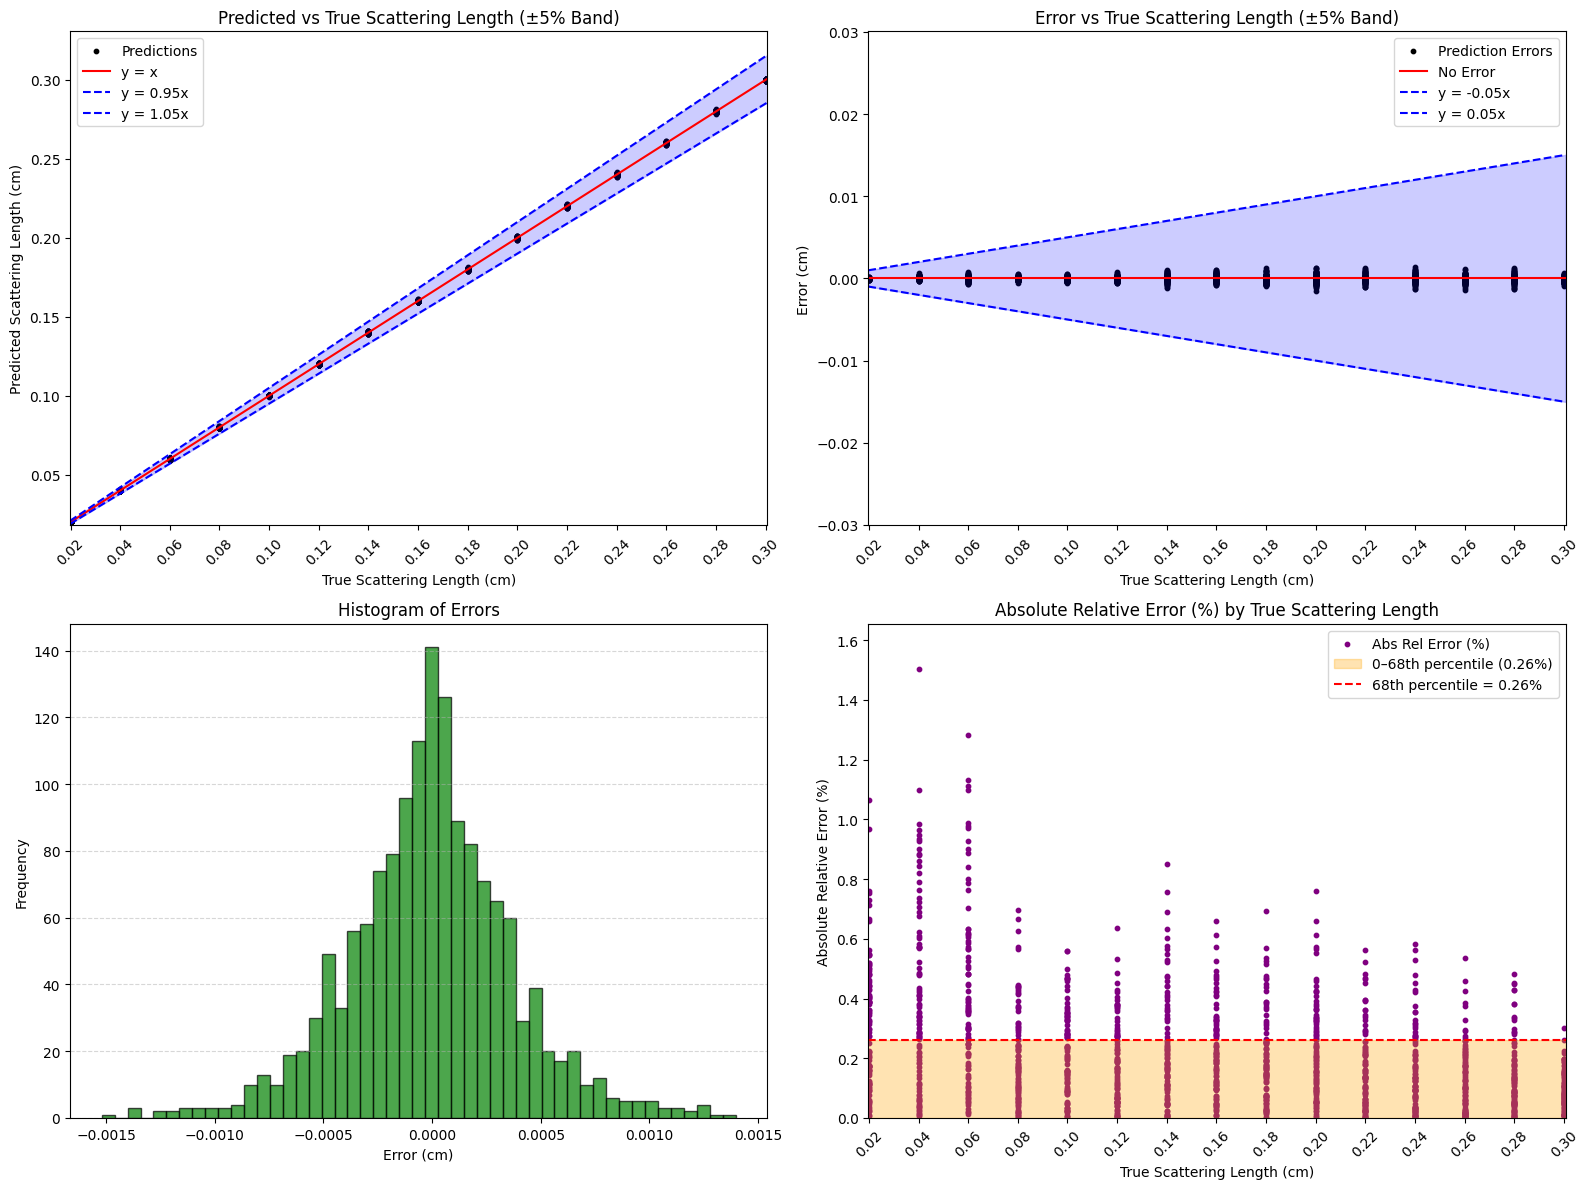

In [5]:
model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_248103/2196323191.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

[Epoch 1/150] Train Loss: 0.000004 | Val Loss: 0.000011 | LR: 5e-06
  → Improved val loss. Checkpoint updated at epoch 1.
[Epoch 2/150] Train Loss: 0.000004 | Val Loss: 0.000011 | LR: 5e-06
[Epoch 3/150] Train Loss: 0.000004 | Val Loss: 0.000009 | LR: 5e-06
  → Improved val loss. Checkpoint updated at epoch 3.
[Epoch 4/150] Train Loss: 0.000003 | Val Loss: 0.000010 | LR: 5e-06
[Epoch 5/150] Train Loss: 0.000003 | Val Loss: 0.000010 | LR: 5e-06
[Epoch 6/150] Train Loss: 0.000004 | Val Loss: 0.000009 | LR: 5e-06
  → Improved val loss. Checkpoint updated at epoch 6.
[Epoch 7/150] Train Loss: 0.000003 | Val Loss: 0.000009 | LR: 5e-06
[Epoch 8/150] Train Loss: 0.000003 | Val Loss: 0.000008 | LR: 5e-06
  → Improved val loss. Checkpoint updated at epoch 8.
[Epoch 9/150] Train Loss: 0.000003 | Val Loss: 0.000009 | LR: 5e-06
[Epoch 10/150] Train Loss: 0.000003 | Val Loss: 0.000010 | LR: 5e-06
[Epoch 11/150] Train Loss: 0.000003 | Val Loss: 0.000009 | LR: 5e-06
[Epoch 12/150] Train Loss: 0.00000

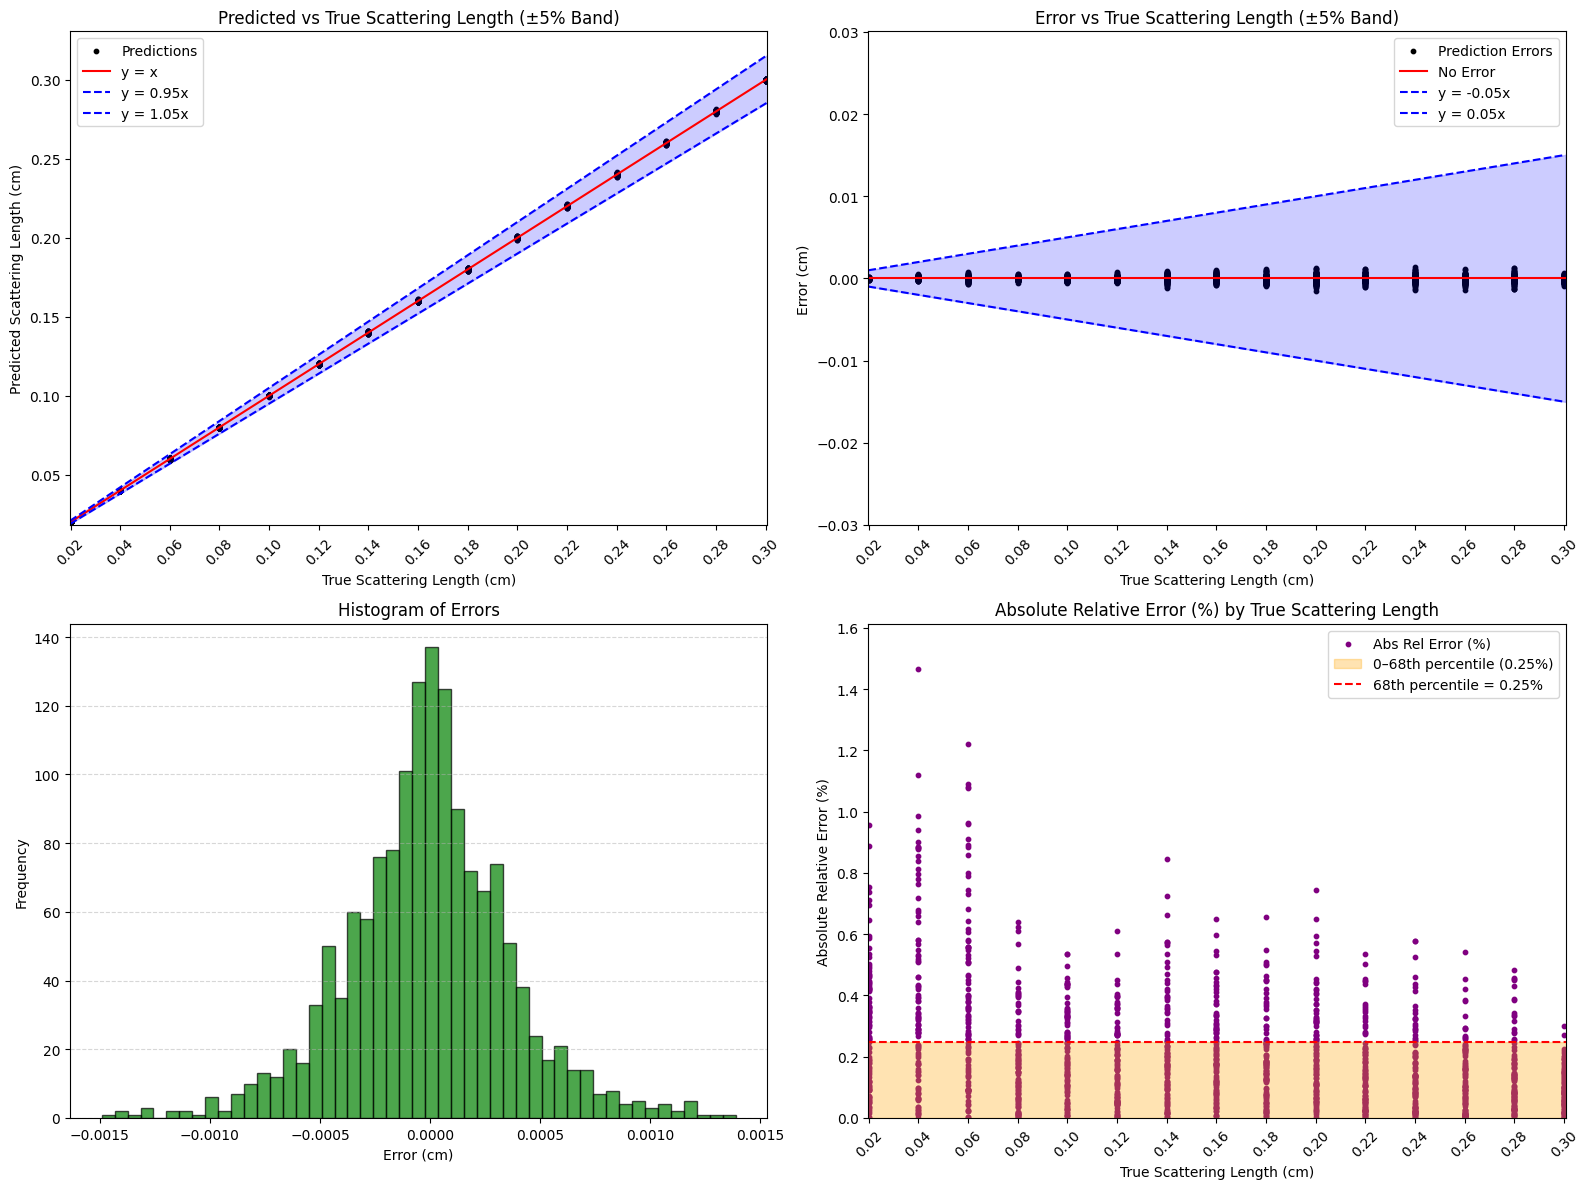

In [6]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=5.0e-6, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.3,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    # Training
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
    train_loss = running_train_loss / len(train_loader.dataset)
    val_loss   = running_val_loss   / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch}/{total_epochs}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트 (종류별로 step 방식 맞추기)
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        if wait >= patience:
            print(f"  → Early stopping at epoch {epoch}.")
            break

# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('.pth', '_0.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.


/tmp/ipykernel_248103/826766694.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)
/usr/local/lib/python3.10/

[Epoch 1/150] Train Loss: 0.000005 | Val Loss: 0.000010 | LR: 1e-05
  → Improved val loss. Checkpoint updated at epoch 1.
[Epoch 2/150] Train Loss: 0.000005 | Val Loss: 0.000009 | LR: 1e-05
  → Improved val loss. Checkpoint updated at epoch 2.
[Epoch 3/150] Train Loss: 0.000004 | Val Loss: 0.000013 | LR: 1e-05
[Epoch 4/150] Train Loss: 0.000005 | Val Loss: 0.000010 | LR: 1e-05
[Epoch 5/150] Train Loss: 0.000004 | Val Loss: 0.000011 | LR: 1e-05
[Epoch 6/150] Train Loss: 0.000003 | Val Loss: 0.000008 | LR: 6e-06
  → Improved val loss. Checkpoint updated at epoch 6.
[Epoch 7/150] Train Loss: 0.000003 | Val Loss: 0.000009 | LR: 6e-06
[Epoch 8/150] Train Loss: 0.000003 | Val Loss: 0.000010 | LR: 6e-06
[Epoch 9/150] Train Loss: 0.000003 | Val Loss: 0.000009 | LR: 6e-06
[Epoch 10/150] Train Loss: 0.000002 | Val Loss: 0.000008 | LR: 3.6e-06
  → Improved val loss. Checkpoint updated at epoch 10.
[Epoch 11/150] Train Loss: 0.000002 | Val Loss: 0.000008 | LR: 3.6e-06
  → Improved val loss. Checkp

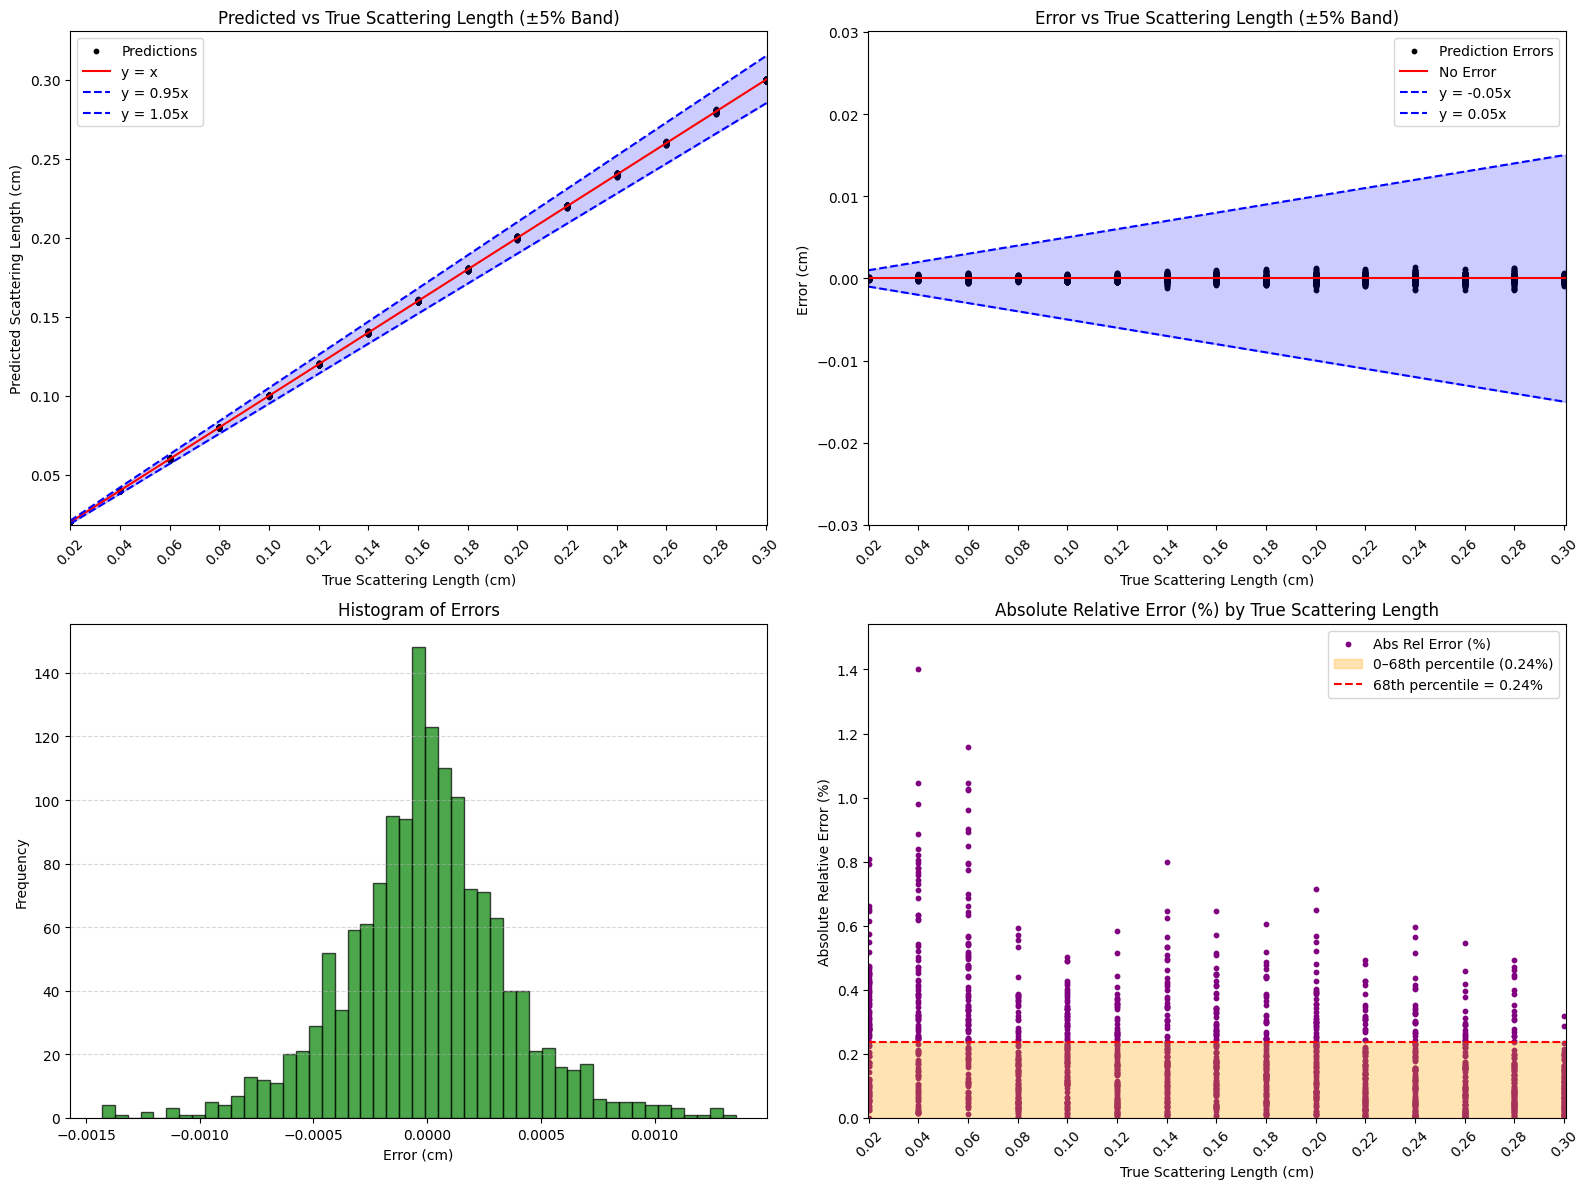

In [8]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=1.0e-5, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.6,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    # Training
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
    train_loss = running_train_loss / len(train_loader.dataset)
    val_loss   = running_val_loss   / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch}/{total_epochs}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트 (종류별로 step 방식 맞추기)
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        if wait >= patience:
            print(f"  → Early stopping at epoch {epoch}.")
            break

# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('.pth', '_0.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_248103/4040794582.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

[Epoch 1/150] Train Loss: 0.000005 | Val Loss: 0.000008 | LR: 1e-05
  → Improved val loss. Checkpoint updated at epoch 1.
[Epoch 2/150] Train Loss: 0.000004 | Val Loss: 0.000009 | LR: 1e-05
[Epoch 3/150] Train Loss: 0.000004 | Val Loss: 0.000012 | LR: 1e-05
[Epoch 4/150] Train Loss: 0.000004 | Val Loss: 0.000008 | LR: 1e-05
[Epoch 5/150] Train Loss: 0.000002 | Val Loss: 0.000008 | LR: 6e-06
[Epoch 6/150] Train Loss: 0.000002 | Val Loss: 0.000008 | LR: 6e-06
  → Improved val loss. Checkpoint updated at epoch 6.
[Epoch 7/150] Train Loss: 0.000002 | Val Loss: 0.000008 | LR: 6e-06
  → Improved val loss. Checkpoint updated at epoch 7.
[Epoch 8/150] Train Loss: 0.000003 | Val Loss: 0.000009 | LR: 6e-06
[Epoch 9/150] Train Loss: 0.000003 | Val Loss: 0.000013 | LR: 6e-06
[Epoch 10/150] Train Loss: 0.000003 | Val Loss: 0.000009 | LR: 6e-06
[Epoch 11/150] Train Loss: 0.000002 | Val Loss: 0.000007 | LR: 3.6e-06
  → Improved val loss. Checkpoint updated at epoch 11.
[Epoch 12/150] Train Loss: 0.00

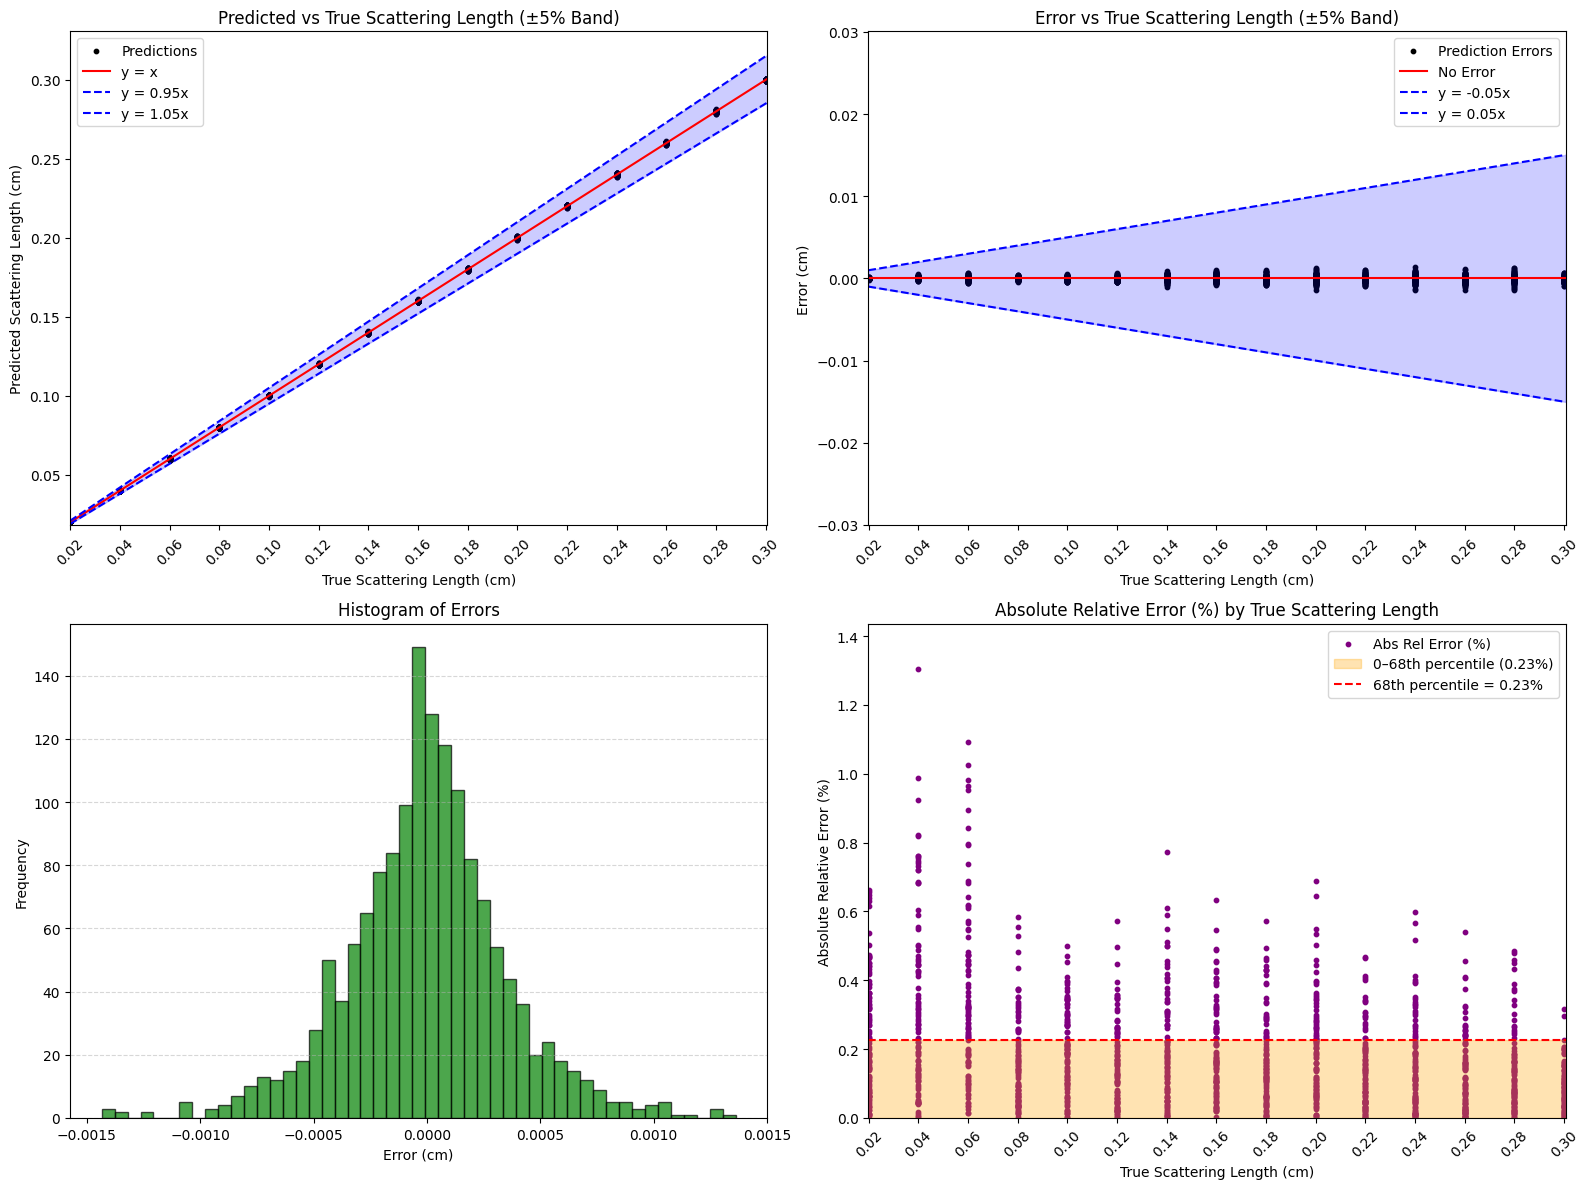

In [9]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0_0.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=1.0e-5, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.6,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    # Training
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
    train_loss = running_train_loss / len(train_loader.dataset)
    val_loss   = running_val_loss   / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch}/{total_epochs}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트 (종류별로 step 방식 맞추기)
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        if wait >= patience:
            print(f"  → Early stopping at epoch {epoch}.")
            break

# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('_0.pth', '_1.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_248103/2916977164.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

[Epoch 1/150] Train Loss: 0.000001 | Val Loss: 0.000007 | LR: 7e-07
  → Improved val loss. Checkpoint updated at epoch 1.
[Epoch 2/150] Train Loss: 0.000001 | Val Loss: 0.000007 | LR: 7e-07
  → Improved val loss. Checkpoint updated at epoch 2.
[Epoch 3/150] Train Loss: 0.000001 | Val Loss: 0.000007 | LR: 7e-07
  → Improved val loss. Checkpoint updated at epoch 3.
[Epoch 4/150] Train Loss: 0.000001 | Val Loss: 0.000007 | LR: 7e-07
[Epoch 5/150] Train Loss: 0.000001 | Val Loss: 0.000007 | LR: 7e-07
[Epoch 6/150] Train Loss: 0.000001 | Val Loss: 0.000007 | LR: 7e-07
  → Improved val loss. Checkpoint updated at epoch 6.
[Epoch 7/150] Train Loss: 0.000001 | Val Loss: 0.000007 | LR: 7e-07
[Epoch 8/150] Train Loss: 0.000001 | Val Loss: 0.000007 | LR: 7e-07
[Epoch 9/150] Train Loss: 0.000001 | Val Loss: 0.000007 | LR: 7e-07
[Epoch 10/150] Train Loss: 0.000001 | Val Loss: 0.000007 | LR: 3.5e-07
[Epoch 11/150] Train Loss: 0.000001 | Val Loss: 0.000007 | LR: 3.5e-07
[Epoch 12/150] Train Loss: 0.0

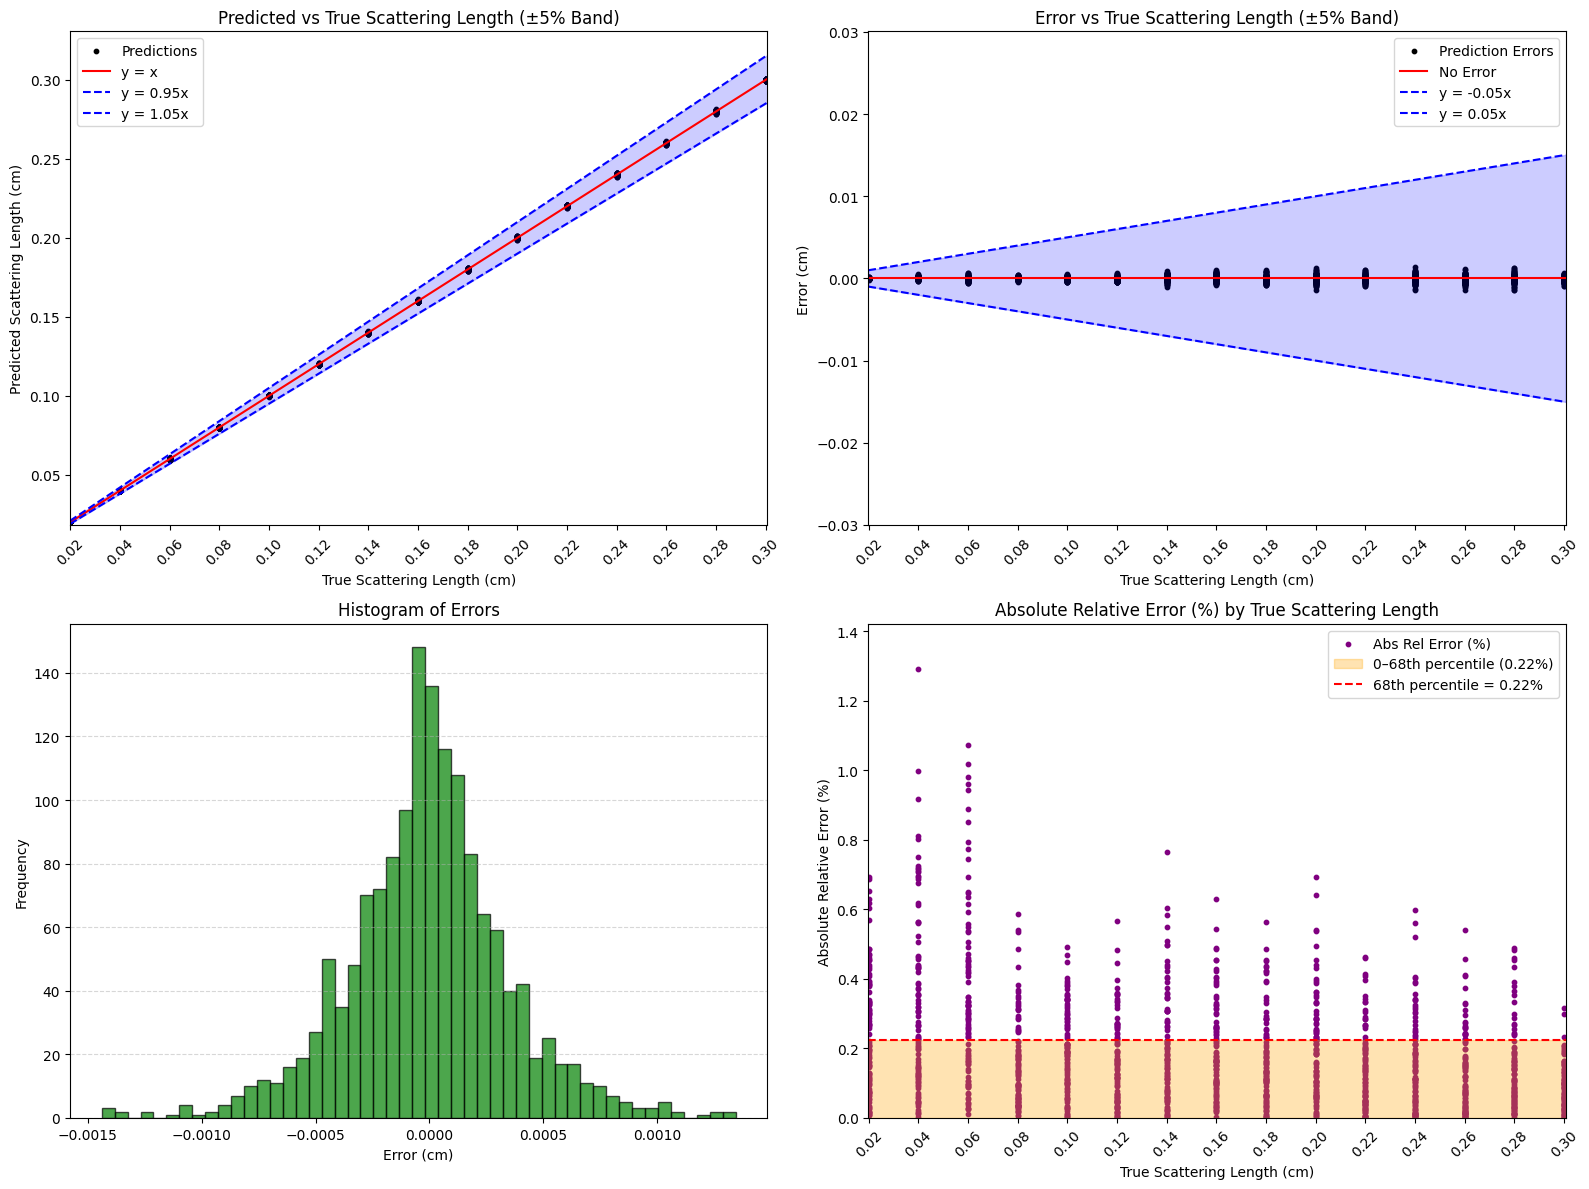

In [10]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0_1.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=0.7e-6, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    # Training
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
    train_loss = running_train_loss / len(train_loader.dataset)
    val_loss   = running_val_loss   / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch}/{total_epochs}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트 (종류별로 step 방식 맞추기)
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        if wait >= patience:
            print(f"  → Early stopping at epoch {epoch}.")
            break

# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('_1.pth', '_2.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.

[Epoch 1/150]


/tmp/ipykernel_248103/216697364.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


Train Loss: 0.000068 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000011 | LR: 3e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 1.

[Epoch 2/150]
Train Loss: 0.000039 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000043 | LR: 3e-05
  → ❌ No improvement. Wait = 1/10

[Epoch 3/150]
Train Loss: 0.000042 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000010 | LR: 3e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 3.

[Epoch 4/150]
Train Loss: 0.000035 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000026 | LR: 3e-05
  → ❌ No improvement. Wait = 1/10

[Epoch 5/150]
Train Loss: 0.000048 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000016 | LR: 3e-05
  → ❌ No improvement. Wait = 2/10

[Epoch 6/150]
Train Loss: 0.000029 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000009 | LR: 3e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 6.

[Epoch 7/150]
Train Loss: 0.000057 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000110 | LR: 3e-05
  →

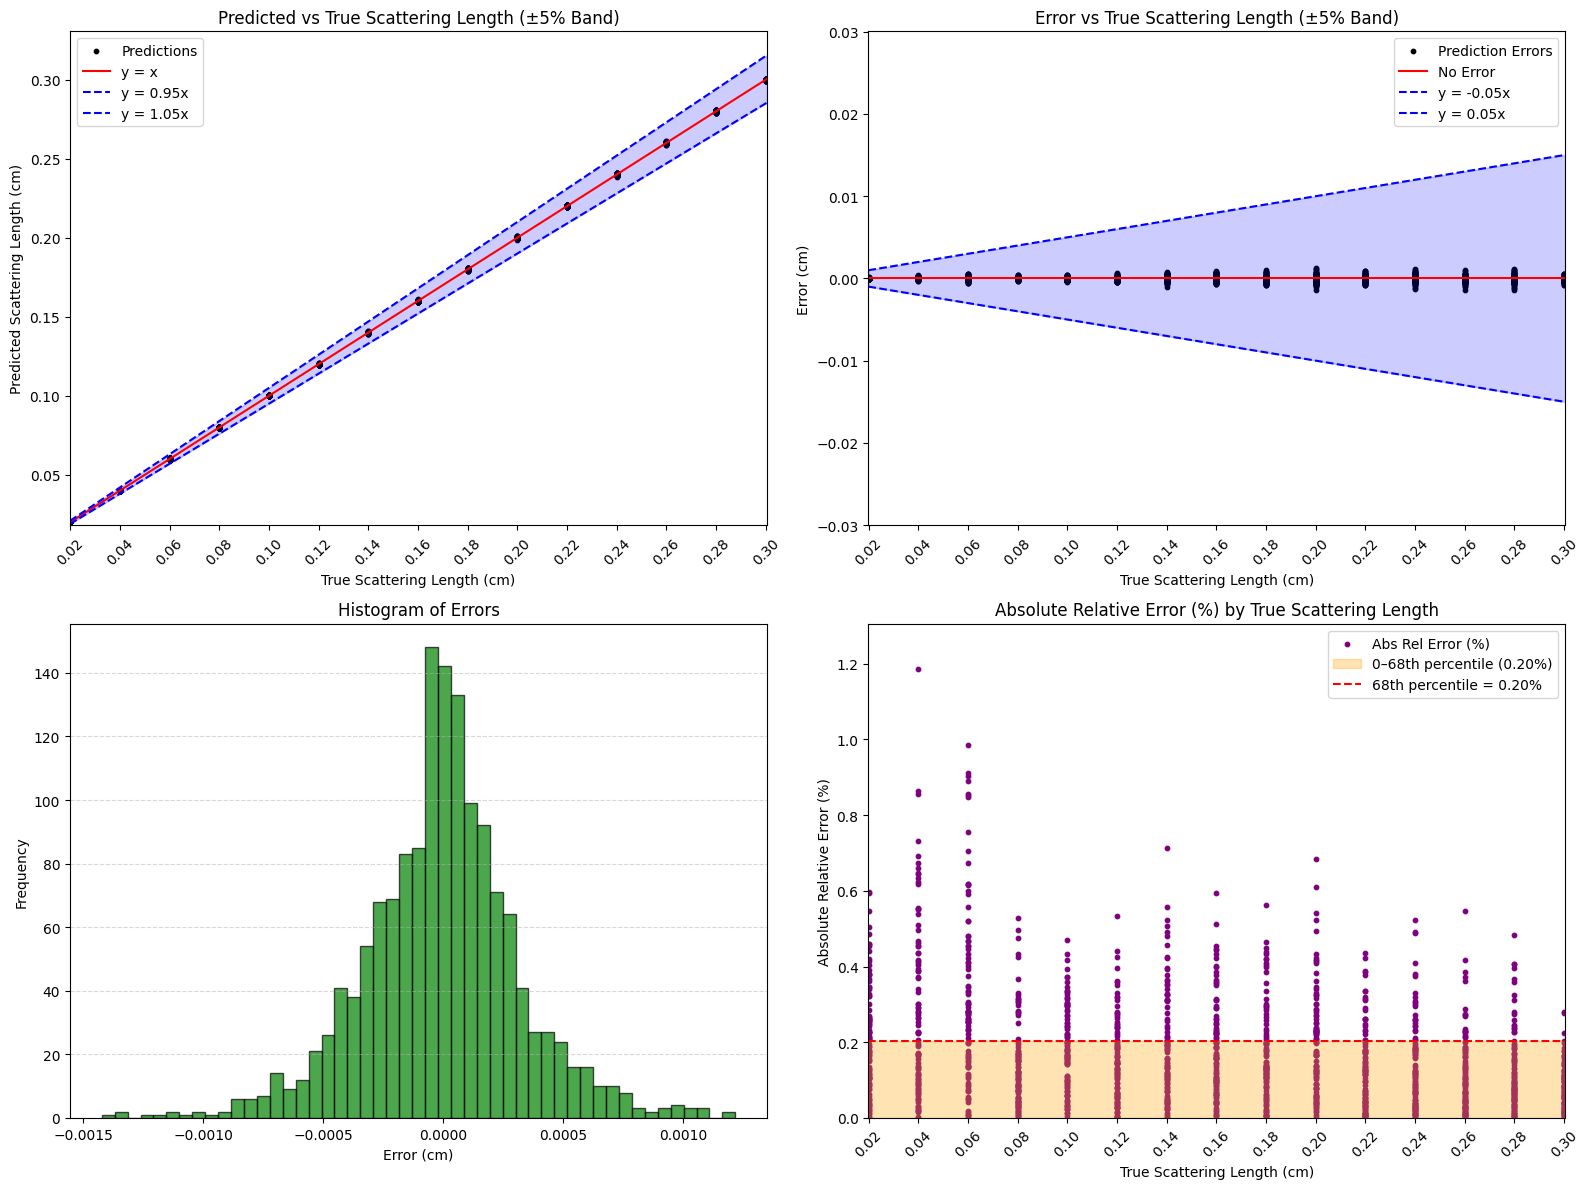

In [12]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0_2.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    print(f"\n[Epoch {epoch}/{total_epochs}]")
    
    # Training
    model.train()
    running_train_loss = 0.0
    total_train_samples = 0
    total_high_weight = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 정규화 복원 후 weight 계산
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        #print(np.unique(labels_orig))
        weights = np.where(labels_orig > 0.1, 4.0, 1.0)
        weights = torch.tensor(weights, dtype=torch.float32).to(device)

        # 통계용 count
        total_train_samples += labels.size(0)
        total_high_weight += (weights == 2.0).sum().item()

        optimizer.zero_grad()
        outputs = model(images)

        # weighted loss 적용
        loss = (criterion(outputs, labels) * weights).mean()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

    train_loss = running_train_loss / total_train_samples if total_train_samples > 0 else float('inf')
    high_ratio = total_high_weight / total_train_samples * 100

    print(f"Train Loss: {train_loss:.6f} | High-weight samples: {total_high_weight}/{total_train_samples} ({high_ratio:.2f}%)")

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → ✅ Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        print(f"  → ❌ No improvement. Wait = {wait}/{patience}")
        if wait >= patience:
            print(f"  → 🛑 Early stopping triggered at epoch {epoch}.")
            break



# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('.pth', '_weight_0.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.

[Epoch 1/150]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_248103/3453424613.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

Train Loss: 0.000025 | High-weight samples: 5600/12000 (46.67%)
Val Loss: 0.000017 | LR: 3e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 1.

[Epoch 2/150]
Train Loss: 0.000047 | High-weight samples: 5600/12000 (46.67%)
Val Loss: 0.000011 | LR: 3e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 2.

[Epoch 3/150]
Train Loss: 0.000008 | High-weight samples: 5600/12000 (46.67%)
Val Loss: 0.000017 | LR: 3e-05
  → ❌ No improvement. Wait = 1/10

[Epoch 4/150]
Train Loss: 0.000026 | High-weight samples: 5600/12000 (46.67%)
Val Loss: 0.000014 | LR: 3e-05
  → ❌ No improvement. Wait = 2/10

[Epoch 5/150]
Train Loss: 0.000028 | High-weight samples: 5600/12000 (46.67%)
Val Loss: 0.000014 | LR: 3e-05
  → ❌ No improvement. Wait = 3/10

[Epoch 6/150]
Train Loss: 0.000004 | High-weight samples: 5600/12000 (46.67%)
Val Loss: 0.000006 | LR: 1.5e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 6.

[Epoch 7/150]
Train Loss: 0.000004 | High-weight samples: 5600/12000 (46.67%)
Val 

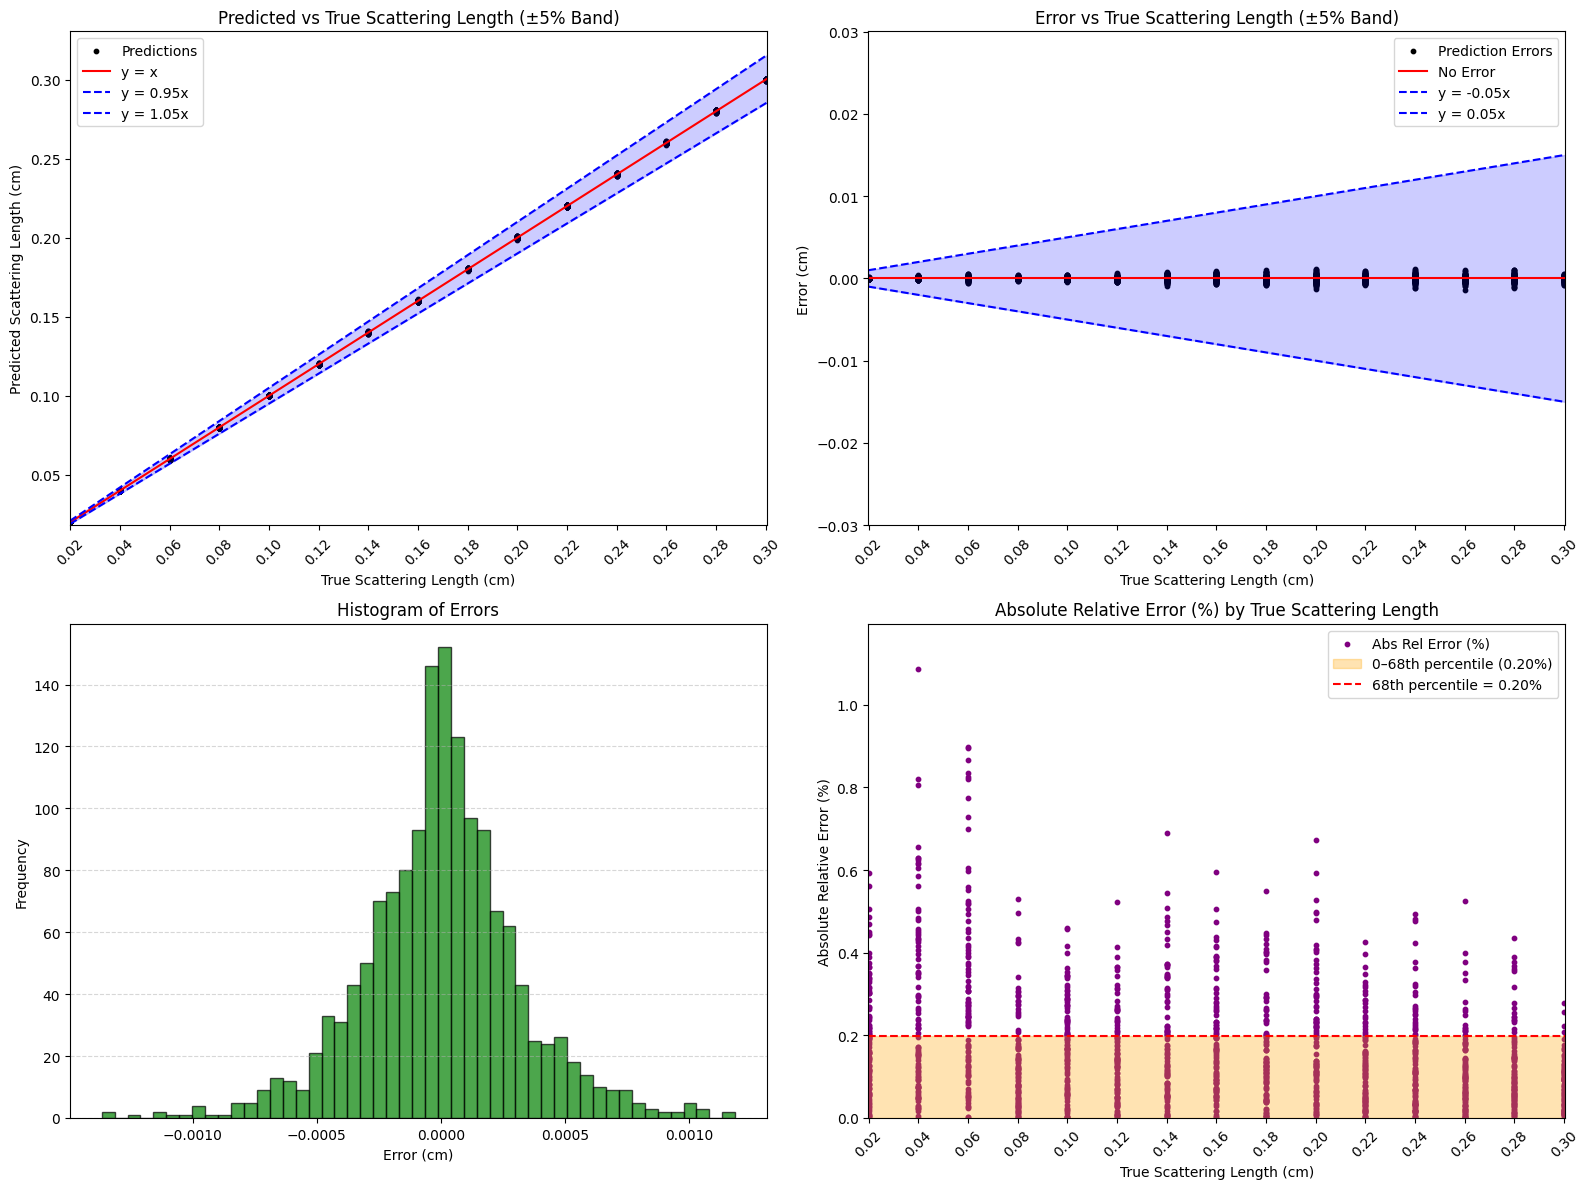

In [13]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0_2.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    print(f"\n[Epoch {epoch}/{total_epochs}]")
    
    model.train()
    running_train_loss = 0.0
    total_train_samples = 0
    total_high_weight = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        HIGH_WEIGHT = 3.0
        LOW_WEIGHT = 1.0
        
        # label을 기준으로 가중치 생성
        weights = torch.where(labels > 0.1, HIGH_WEIGHT, LOW_WEIGHT)
        total_high_weight += (weights == HIGH_WEIGHT).sum().item()
        batch_size = images.size(0)
        total_train_samples += batch_size
        
        optimizer.zero_grad()
        outputs = model(images)

        # 가중치 적용된 loss
        loss = (criterion(outputs, labels) * weights).mean()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * batch_size

    train_loss = running_train_loss / total_train_samples if total_train_samples > 0 else float('inf')
    high_ratio = (total_high_weight / (total_train_samples * labels.numel() // batch_size)) * 100  # 비율(%) 계산

    print(f"Train Loss: {train_loss:.6f} | High-weight samples: {total_high_weight}/{total_train_samples * labels.numel() // batch_size} ({high_ratio:.2f}%)")

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → ✅ Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        print(f"  → ❌ No improvement. Wait = {wait}/{patience}")
        if wait >= patience:
            print(f"  → 🛑 Early stopping triggered at epoch {epoch}.")
            break



# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('.pth', '_w_0.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.

[Epoch 1/150]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_248103/3124667884.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

Train Loss: 0.000006 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000009 | LR: 1e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 1.

[Epoch 2/150]
Train Loss: 0.000007 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000006 | LR: 1e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 2.

[Epoch 3/150]
Train Loss: 0.000008 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000006 | LR: 1e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 3.

[Epoch 4/150]
Train Loss: 0.000004 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000006 | LR: 1e-05
  → ❌ No improvement. Wait = 1/10

[Epoch 5/150]
Train Loss: 0.000006 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000007 | LR: 1e-05
  → ❌ No improvement. Wait = 2/10

[Epoch 6/150]
Train Loss: 0.000006 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000008 | LR: 1e-05
  → ❌ No improvement. Wait = 3/10

[Epoch 7/150]
Train Loss: 0.000002 | High-weight samples: 4800/12000 (40.00%)
Val Lo

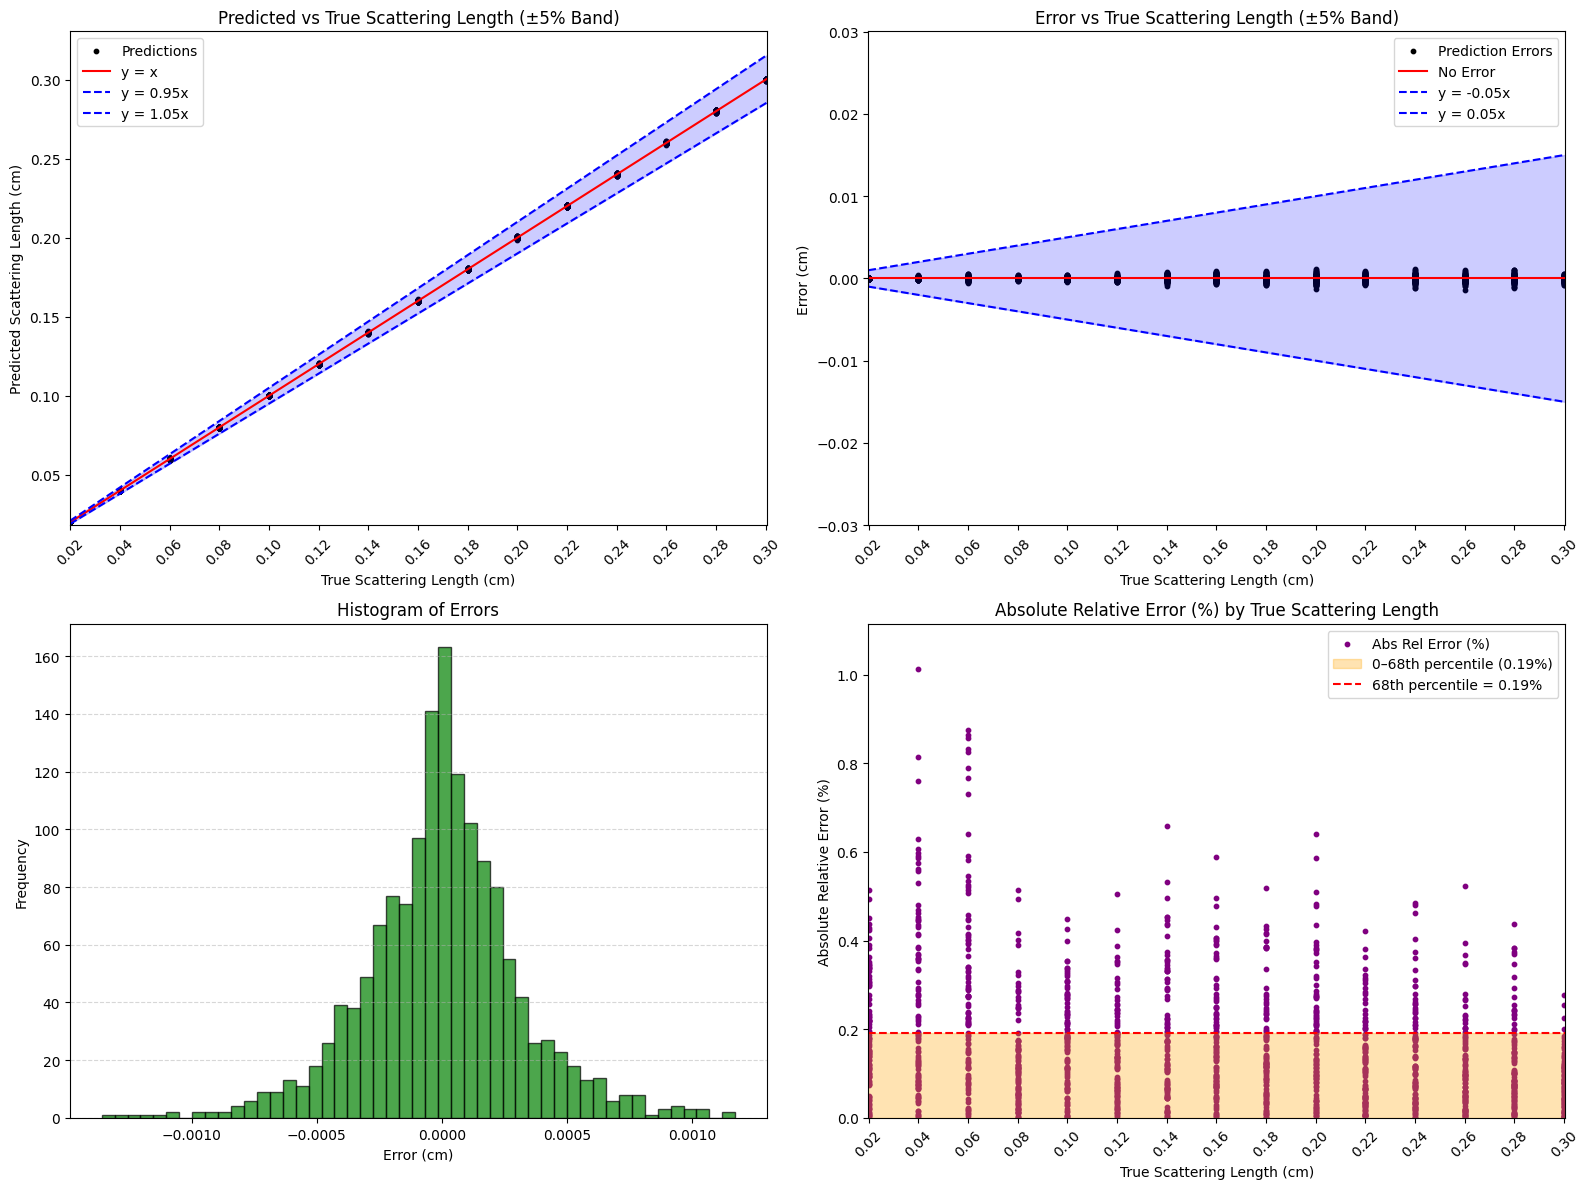

In [14]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0_2_w_0.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    print(f"\n[Epoch {epoch}/{total_epochs}]")
    
    model.train()
    running_train_loss = 0.0
    total_train_samples = 0
    total_high_weight = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        HIGH_WEIGHT = 4.3
        LOW_WEIGHT = 1.0
        
        # label을 기준으로 가중치 생성
        weights = torch.where(labels > 0.15, HIGH_WEIGHT, LOW_WEIGHT)
        total_high_weight += (weights == HIGH_WEIGHT).sum().item()
        batch_size = images.size(0)
        total_train_samples += batch_size
        
        optimizer.zero_grad()
        outputs = model(images)

        # 가중치 적용된 loss
        loss = (criterion(outputs, labels) * weights).mean()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * batch_size

    train_loss = running_train_loss / total_train_samples if total_train_samples > 0 else float('inf')
    high_ratio = (total_high_weight / (total_train_samples * labels.numel() // batch_size)) * 100  # 비율(%) 계산

    print(f"Train Loss: {train_loss:.6f} | High-weight samples: {total_high_weight}/{total_train_samples * labels.numel() // batch_size} ({high_ratio:.2f}%)")

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → ✅ Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        print(f"  → ❌ No improvement. Wait = {wait}/{patience}")
        if wait >= patience:
            print(f"  → 🛑 Early stopping triggered at epoch {epoch}.")
            break



# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('0.pth', '1.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.

[Epoch 1/150]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_248103/734146501.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you

Train Loss: 0.000004 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000007 | LR: 1e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 1.

[Epoch 2/150]
Train Loss: 0.000002 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000007 | LR: 1e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 2.

[Epoch 3/150]
Train Loss: 0.000004 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000011 | LR: 1e-05
  → ❌ No improvement. Wait = 1/10

[Epoch 4/150]
Train Loss: 0.000004 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000007 | LR: 1e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 4.

[Epoch 5/150]
Train Loss: 0.000003 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000010 | LR: 1e-05
  → ❌ No improvement. Wait = 1/10

[Epoch 6/150]
Train Loss: 0.000003 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000006 | LR: 1e-05
  → ✅ Improved val loss. Checkpoint updated at epoch 6.

[Epoch 7/150]
Train Loss: 0.000003 | High-weight samples: 4800

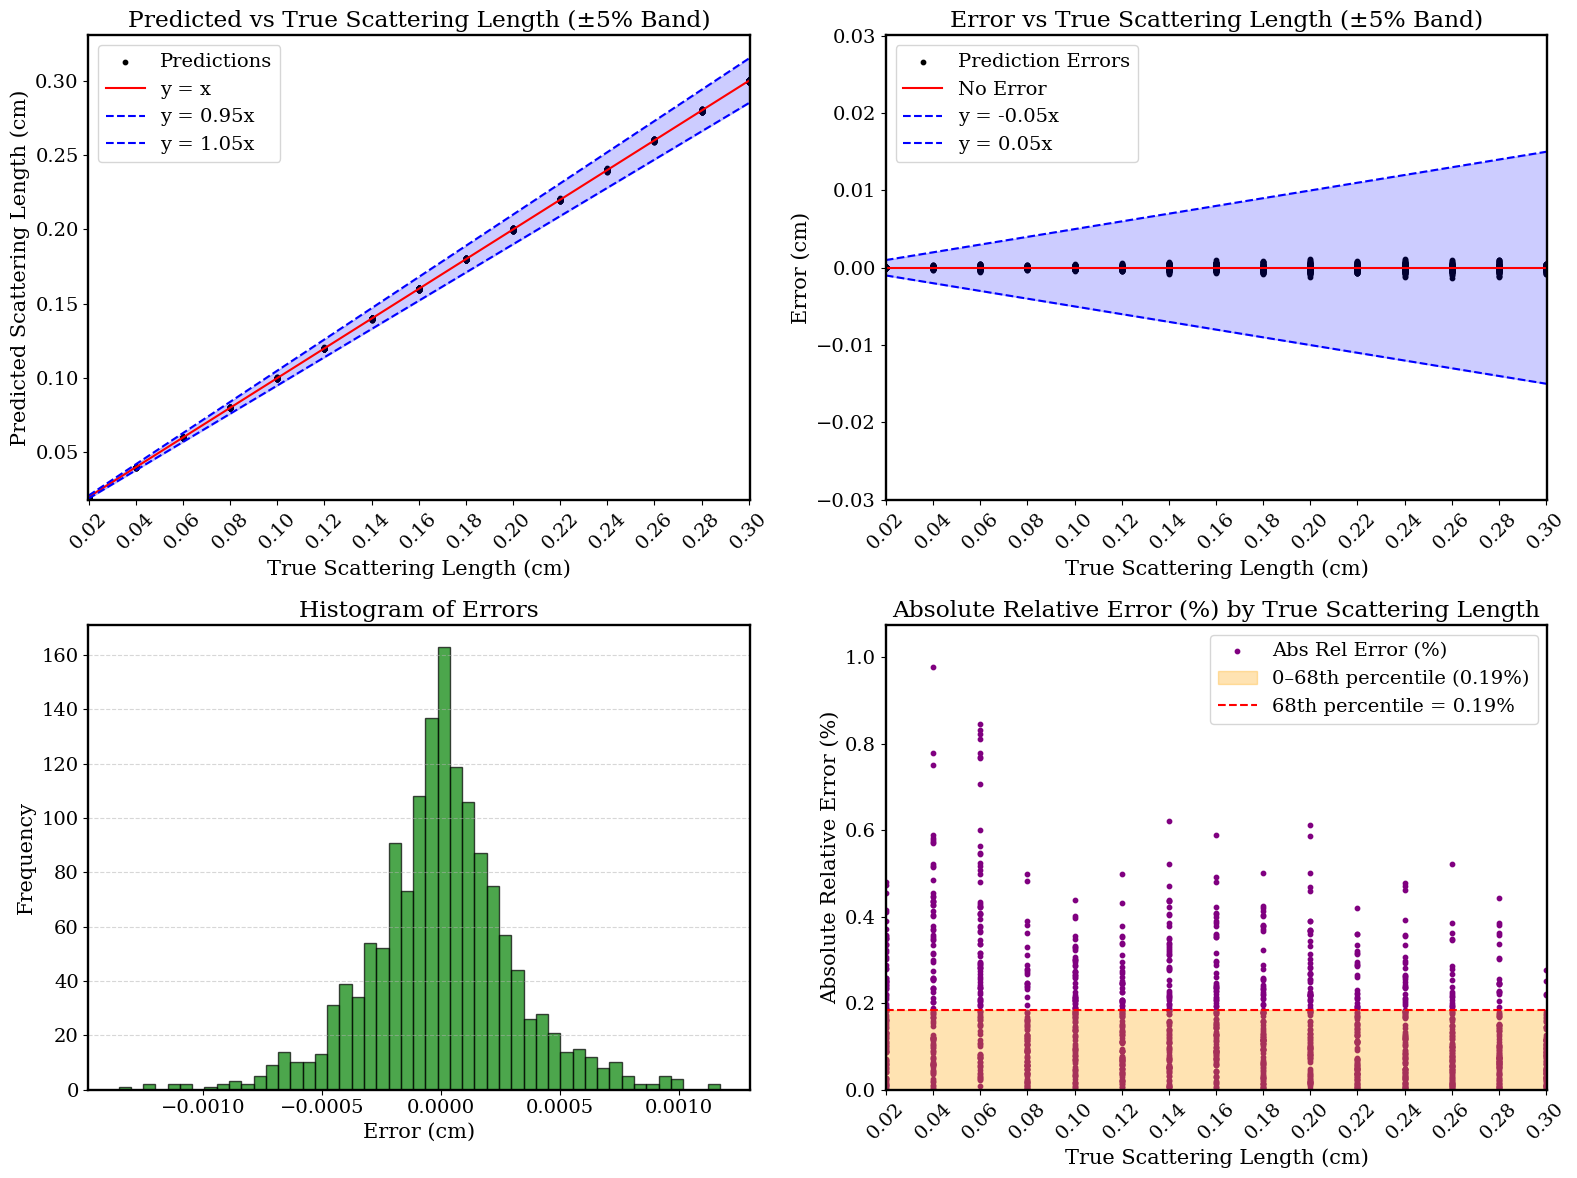

In [17]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0_2_w_1.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    print(f"\n[Epoch {epoch}/{total_epochs}]")
    
    model.train()
    running_train_loss = 0.0
    total_train_samples = 0
    total_high_weight = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        HIGH_WEIGHT = 1.0
        LOW_WEIGHT = 1.5
        
        # label을 기준으로 가중치 생성
        weights = torch.where(labels > 0.15, HIGH_WEIGHT, LOW_WEIGHT)
        total_high_weight += (weights == HIGH_WEIGHT).sum().item()
        batch_size = images.size(0)
        total_train_samples += batch_size
        
        optimizer.zero_grad()
        outputs = model(images)

        # 가중치 적용된 loss
        loss = (criterion(outputs, labels) * weights).mean()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * batch_size

    train_loss = running_train_loss / total_train_samples if total_train_samples > 0 else float('inf')
    high_ratio = (total_high_weight / (total_train_samples * labels.numel() // batch_size)) * 100  # 비율(%) 계산

    print(f"Train Loss: {train_loss:.6f} | High-weight samples: {total_high_weight}/{total_train_samples * labels.numel() // batch_size} ({high_ratio:.2f}%)")

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → ✅ Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        print(f"  → ❌ No improvement. Wait = {wait}/{patience}")
        if wait >= patience:
            print(f"  → 🛑 Early stopping triggered at epoch {epoch}.")
            break



# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('1.pth', '2.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.

[Epoch 1/150]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_248103/1272206349.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

Train Loss: 0.000002 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000006 | LR: 5e-06
  → ✅ Improved val loss. Checkpoint updated at epoch 1.

[Epoch 2/150]
Train Loss: 0.000001 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000006 | LR: 5e-06
  → ❌ No improvement. Wait = 1/10

[Epoch 3/150]
Train Loss: 0.000002 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000006 | LR: 5e-06
  → ✅ Improved val loss. Checkpoint updated at epoch 3.

[Epoch 4/150]
Train Loss: 0.000001 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000005 | LR: 5e-06
  → ✅ Improved val loss. Checkpoint updated at epoch 4.

[Epoch 5/150]
Train Loss: 0.000001 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000006 | LR: 5e-06
  → ❌ No improvement. Wait = 1/10

[Epoch 6/150]
Train Loss: 0.000002 | High-weight samples: 4800/12000 (40.00%)
Val Loss: 0.000006 | LR: 5e-06
  → ❌ No improvement. Wait = 2/10

[Epoch 7/150]
Train Loss: 0.000001 | High-weight samples: 4800/12000 (40.00%)
Val Lo

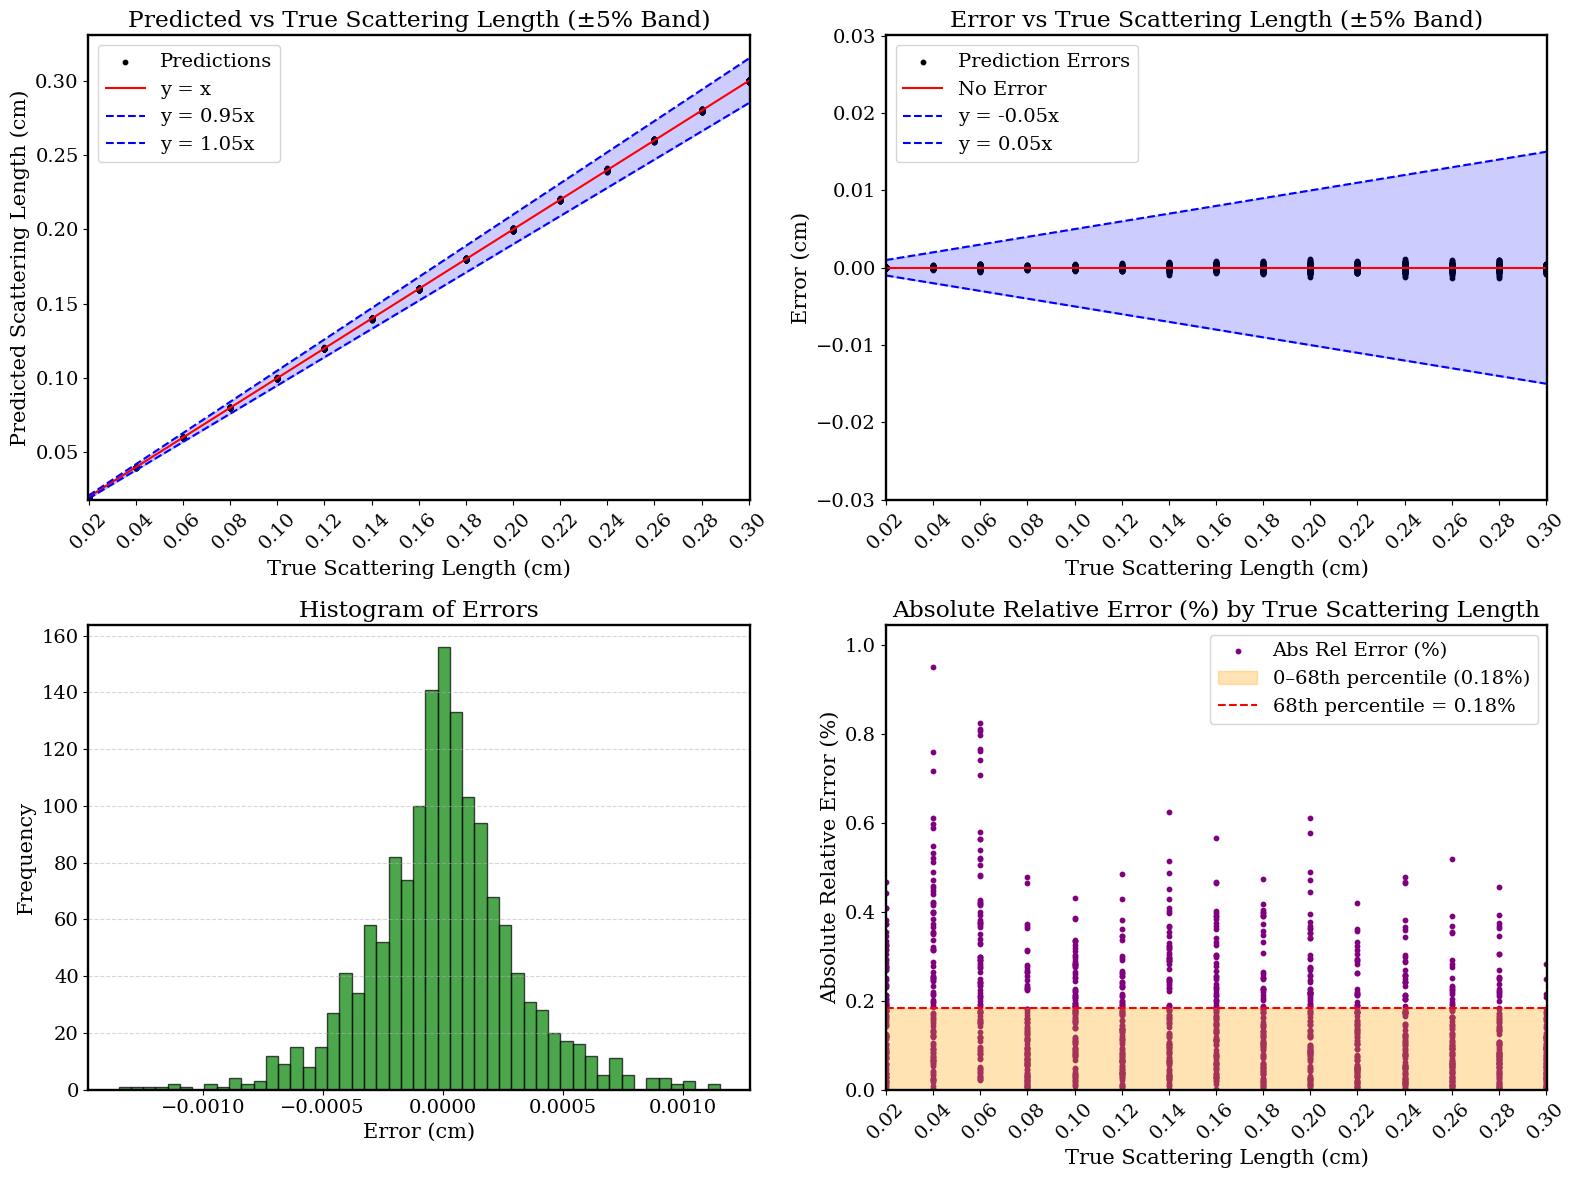

In [18]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0_2_w_2.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    print(f"\n[Epoch {epoch}/{total_epochs}]")
    
    model.train()
    running_train_loss = 0.0
    total_train_samples = 0
    total_high_weight = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        HIGH_WEIGHT = 1.0
        LOW_WEIGHT = 1.5
        
        # label을 기준으로 가중치 생성
        weights = torch.where(labels > 0.15, HIGH_WEIGHT, LOW_WEIGHT)
        total_high_weight += (weights == HIGH_WEIGHT).sum().item()
        batch_size = images.size(0)
        total_train_samples += batch_size
        
        optimizer.zero_grad()
        outputs = model(images)

        # 가중치 적용된 loss
        loss = (criterion(outputs, labels) * weights).mean()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * batch_size

    train_loss = running_train_loss / total_train_samples if total_train_samples > 0 else float('inf')
    high_ratio = (total_high_weight / (total_train_samples * labels.numel() // batch_size)) * 100  # 비율(%) 계산

    print(f"Train Loss: {train_loss:.6f} | High-weight samples: {total_high_weight}/{total_train_samples * labels.numel() // batch_size} ({high_ratio:.2f}%)")

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → ✅ Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        print(f"  → ❌ No improvement. Wait = {wait}/{patience}")
        if wait >= patience:
            print(f"  → 🛑 Early stopping triggered at epoch {epoch}.")
            break



# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('2.pth', '3.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.

[Epoch 1/150]


/tmp/ipykernel_248103/3684287523.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


Train Loss: 0.000000 | High-weight samples: 12000/12000 (100.00%)
Val Loss: 0.000005 | LR: 1e-06
  → ✅ Improved val loss. Checkpoint updated at epoch 1.

[Epoch 2/150]
Train Loss: 0.000000 | High-weight samples: 12000/12000 (100.00%)
Val Loss: 0.000005 | LR: 1e-06
  → ✅ Improved val loss. Checkpoint updated at epoch 2.

[Epoch 3/150]
Train Loss: 0.000000 | High-weight samples: 12000/12000 (100.00%)
Val Loss: 0.000005 | LR: 1e-06
  → ❌ No improvement. Wait = 1/10

[Epoch 4/150]
Train Loss: 0.000000 | High-weight samples: 12000/12000 (100.00%)
Val Loss: 0.000005 | LR: 1e-06
  → ❌ No improvement. Wait = 2/10

[Epoch 5/150]
Train Loss: 0.000000 | High-weight samples: 12000/12000 (100.00%)
Val Loss: 0.000005 | LR: 1e-06
  → ❌ No improvement. Wait = 3/10

[Epoch 6/150]
Train Loss: 0.000000 | High-weight samples: 12000/12000 (100.00%)
Val Loss: 0.000005 | LR: 5e-07
  → ✅ Improved val loss. Checkpoint updated at epoch 6.

[Epoch 7/150]
Train Loss: 0.000000 | High-weight samples: 12000/12000 (1

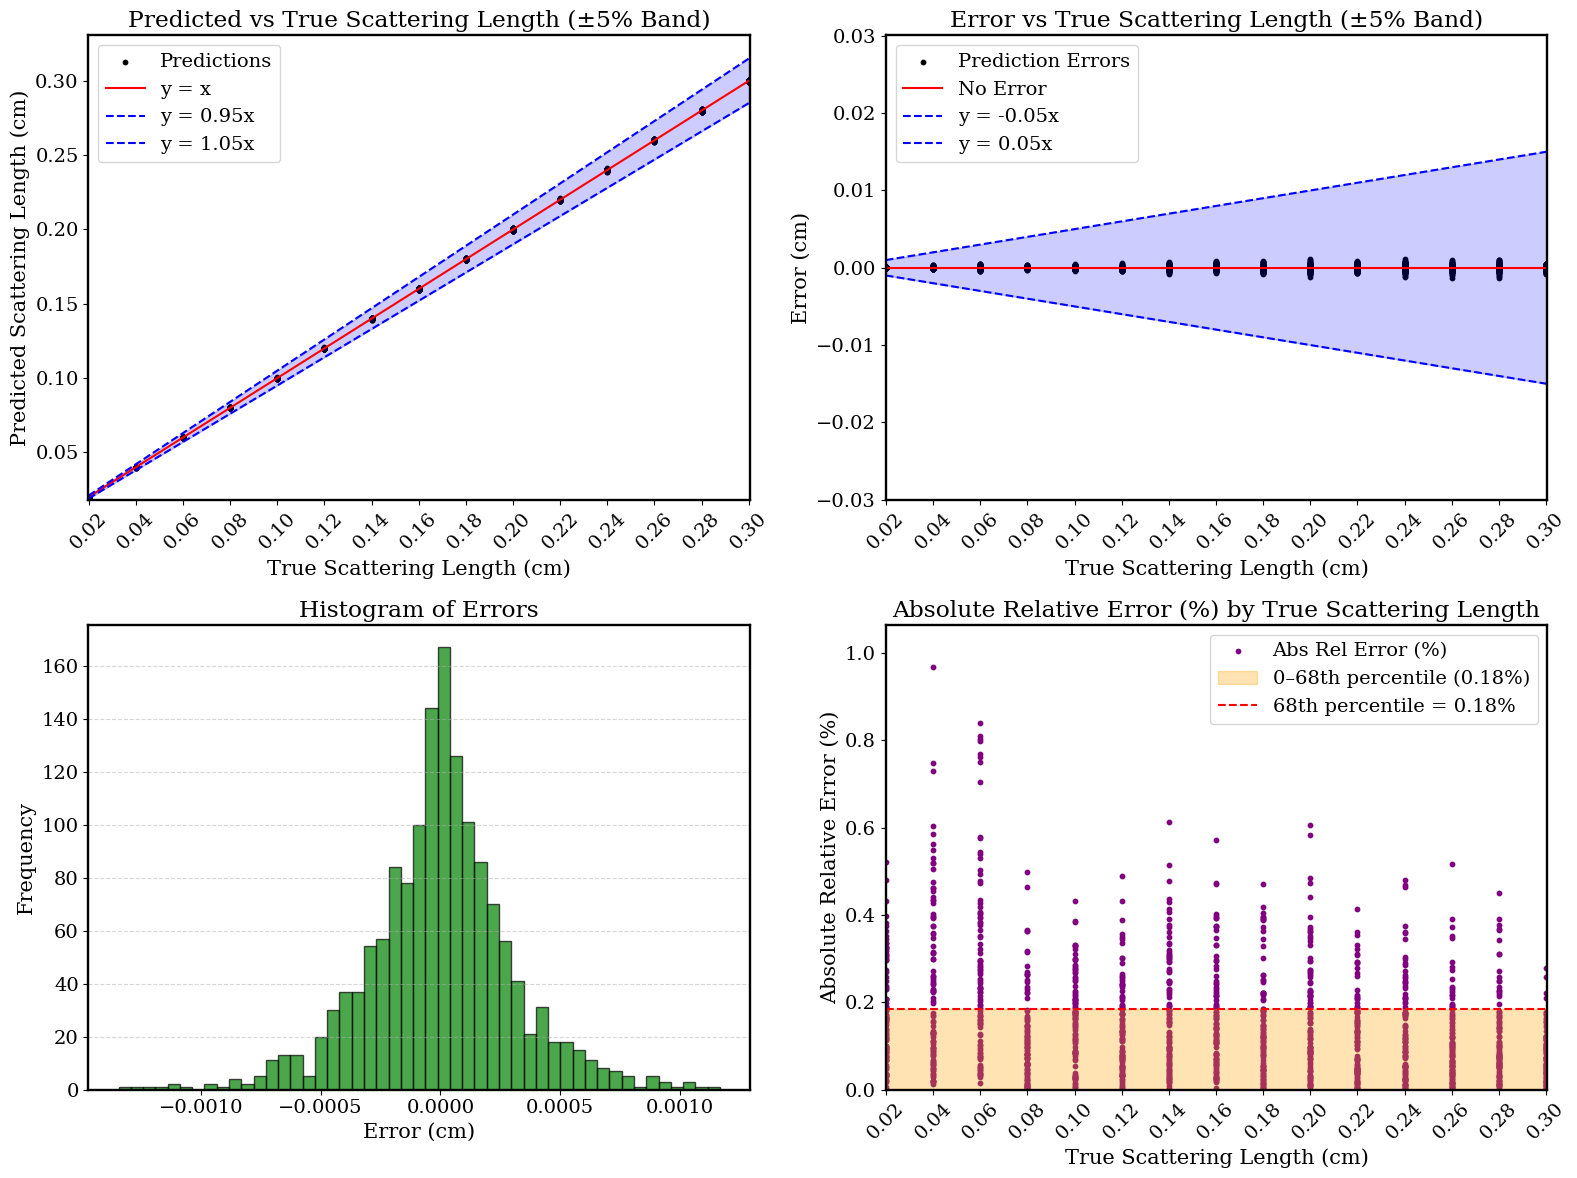

In [21]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0_2_w_3.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=1e-6, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    print(f"\n[Epoch {epoch}/{total_epochs}]")
    
    model.train()
    running_train_loss = 0.0
    total_train_samples = 0
    total_high_weight = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        HIGH_WEIGHT = 1.0
        LOW_WEIGHT = 1.0
        
        # label을 기준으로 가중치 생성
        weights = torch.where(labels > 0.15, HIGH_WEIGHT, LOW_WEIGHT)
        total_high_weight += (weights == HIGH_WEIGHT).sum().item()
        batch_size = images.size(0)
        total_train_samples += batch_size
        
        optimizer.zero_grad()
        outputs = model(images)

        # 가중치 적용된 loss
        loss = (criterion(outputs, labels) * weights).mean()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * batch_size

    train_loss = running_train_loss / total_train_samples if total_train_samples > 0 else float('inf')
    high_ratio = (total_high_weight / (total_train_samples * labels.numel() // batch_size)) * 100  # 비율(%) 계산

    print(f"Train Loss: {train_loss:.6f} | High-weight samples: {total_high_weight}/{total_train_samples * labels.numel() // batch_size} ({high_ratio:.2f}%)")

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → ✅ Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        print(f"  → ❌ No improvement. Wait = {wait}/{patience}")
        if wait >= patience:
            print(f"  → 🛑 Early stopping triggered at epoch {epoch}.")
            break



# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('3.pth', '4.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.

[Epoch 1/150]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_248103/2333740245.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

Train Loss: 0.000001 | High-weight samples: 7200/12000 (60.00%)
Val Loss: 0.000005 | LR: 1e-06
  → ✅ Improved val loss. Checkpoint updated at epoch 1.

[Epoch 2/150]
Train Loss: 0.000001 | High-weight samples: 7200/12000 (60.00%)
Val Loss: 0.000005 | LR: 1e-06
  → ✅ Improved val loss. Checkpoint updated at epoch 2.

[Epoch 3/150]
Train Loss: 0.000001 | High-weight samples: 7200/12000 (60.00%)
Val Loss: 0.000005 | LR: 1e-06
  → ✅ Improved val loss. Checkpoint updated at epoch 3.

[Epoch 4/150]
Train Loss: 0.000001 | High-weight samples: 7200/12000 (60.00%)
Val Loss: 0.000005 | LR: 1e-06
  → ❌ No improvement. Wait = 1/10

[Epoch 5/150]
Train Loss: 0.000001 | High-weight samples: 7200/12000 (60.00%)
Val Loss: 0.000005 | LR: 1e-06
  → ❌ No improvement. Wait = 2/10

[Epoch 6/150]
Train Loss: 0.000001 | High-weight samples: 7200/12000 (60.00%)
Val Loss: 0.000005 | LR: 1e-06
  → ❌ No improvement. Wait = 3/10

[Epoch 7/150]
Train Loss: 0.000000 | High-weight samples: 7200/12000 (60.00%)
Val Lo

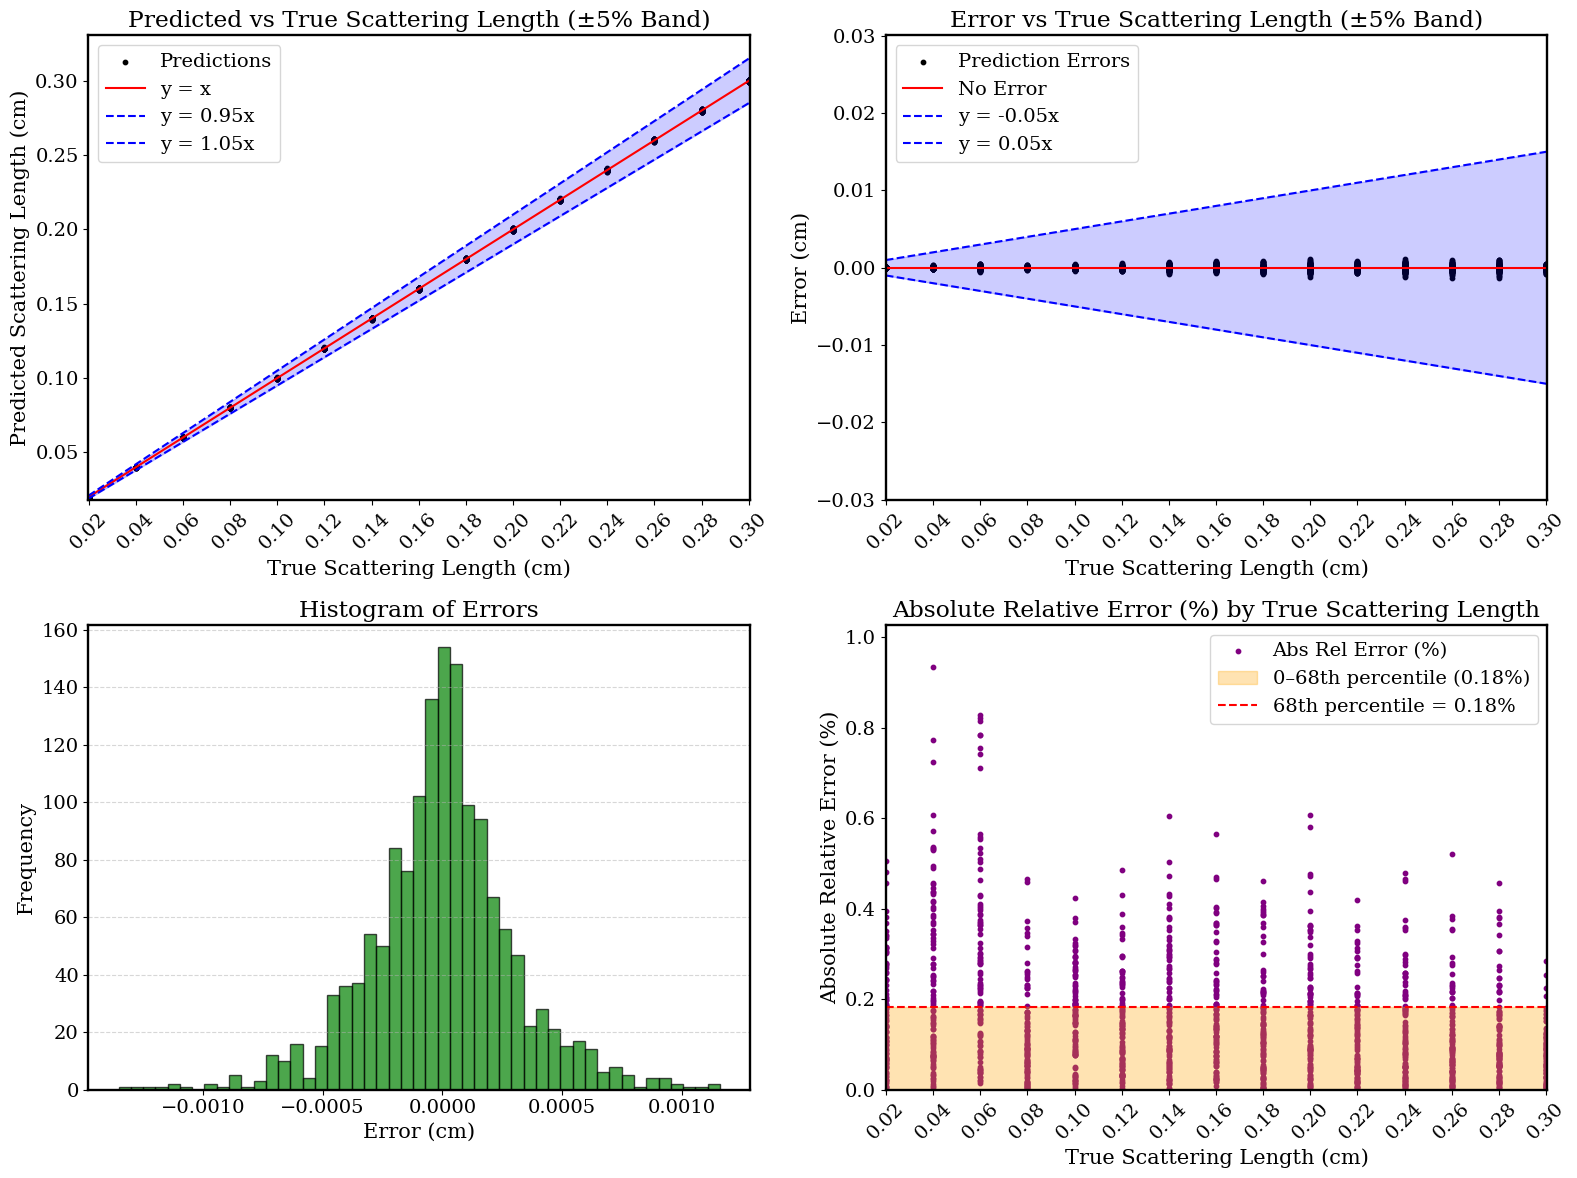

In [24]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0_2_w_4.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=1e-6, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    print(f"\n[Epoch {epoch}/{total_epochs}]")
    
    model.train()
    running_train_loss = 0.0
    total_train_samples = 0
    total_high_weight = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        HIGH_WEIGHT = 1.5
        LOW_WEIGHT = 1.0
        
        # label을 기준으로 가중치 생성
        weights = torch.where(labels < 0.2, HIGH_WEIGHT, LOW_WEIGHT)
        total_high_weight += (weights == HIGH_WEIGHT).sum().item()
        batch_size = images.size(0)
        total_train_samples += batch_size
        
        optimizer.zero_grad()
        outputs = model(images)

        # 가중치 적용된 loss
        loss = (criterion(outputs, labels) * weights).mean()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * batch_size

    train_loss = running_train_loss / total_train_samples if total_train_samples > 0 else float('inf')
    high_ratio = (total_high_weight / (total_train_samples * labels.numel() // batch_size)) * 100  # 비율(%) 계산

    print(f"Train Loss: {train_loss:.6f} | High-weight samples: {total_high_weight}/{total_train_samples * labels.numel() // batch_size} ({high_ratio:.2f}%)")

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → ✅ Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        print(f"  → ❌ No improvement. Wait = {wait}/{patience}")
        if wait >= patience:
            print(f"  → 🛑 Early stopping triggered at epoch {epoch}.")
            break



# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('4.pth', '5.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.

[Epoch 1/150]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_248103/2940280991.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

Train Loss: 0.000000 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000005 | LR: 5e-07
  → ✅ Improved val loss. Checkpoint updated at epoch 1.

[Epoch 2/150]
Train Loss: 0.000000 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000005 | LR: 5e-07
  → ❌ No improvement. Wait = 1/10

[Epoch 3/150]
Train Loss: 0.000000 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000005 | LR: 5e-07
  → ✅ Improved val loss. Checkpoint updated at epoch 3.

[Epoch 4/150]
Train Loss: 0.000000 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000005 | LR: 5e-07
  → ❌ No improvement. Wait = 1/10

[Epoch 5/150]
Train Loss: 0.000000 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000005 | LR: 5e-07
  → ✅ Improved val loss. Checkpoint updated at epoch 5.

[Epoch 6/150]
Train Loss: 0.000000 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000005 | LR: 5e-07
  → ❌ No improvement. Wait = 1/10

[Epoch 7/150]
Train Loss: 0.000000 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000005 | LR: 5e-07
  →

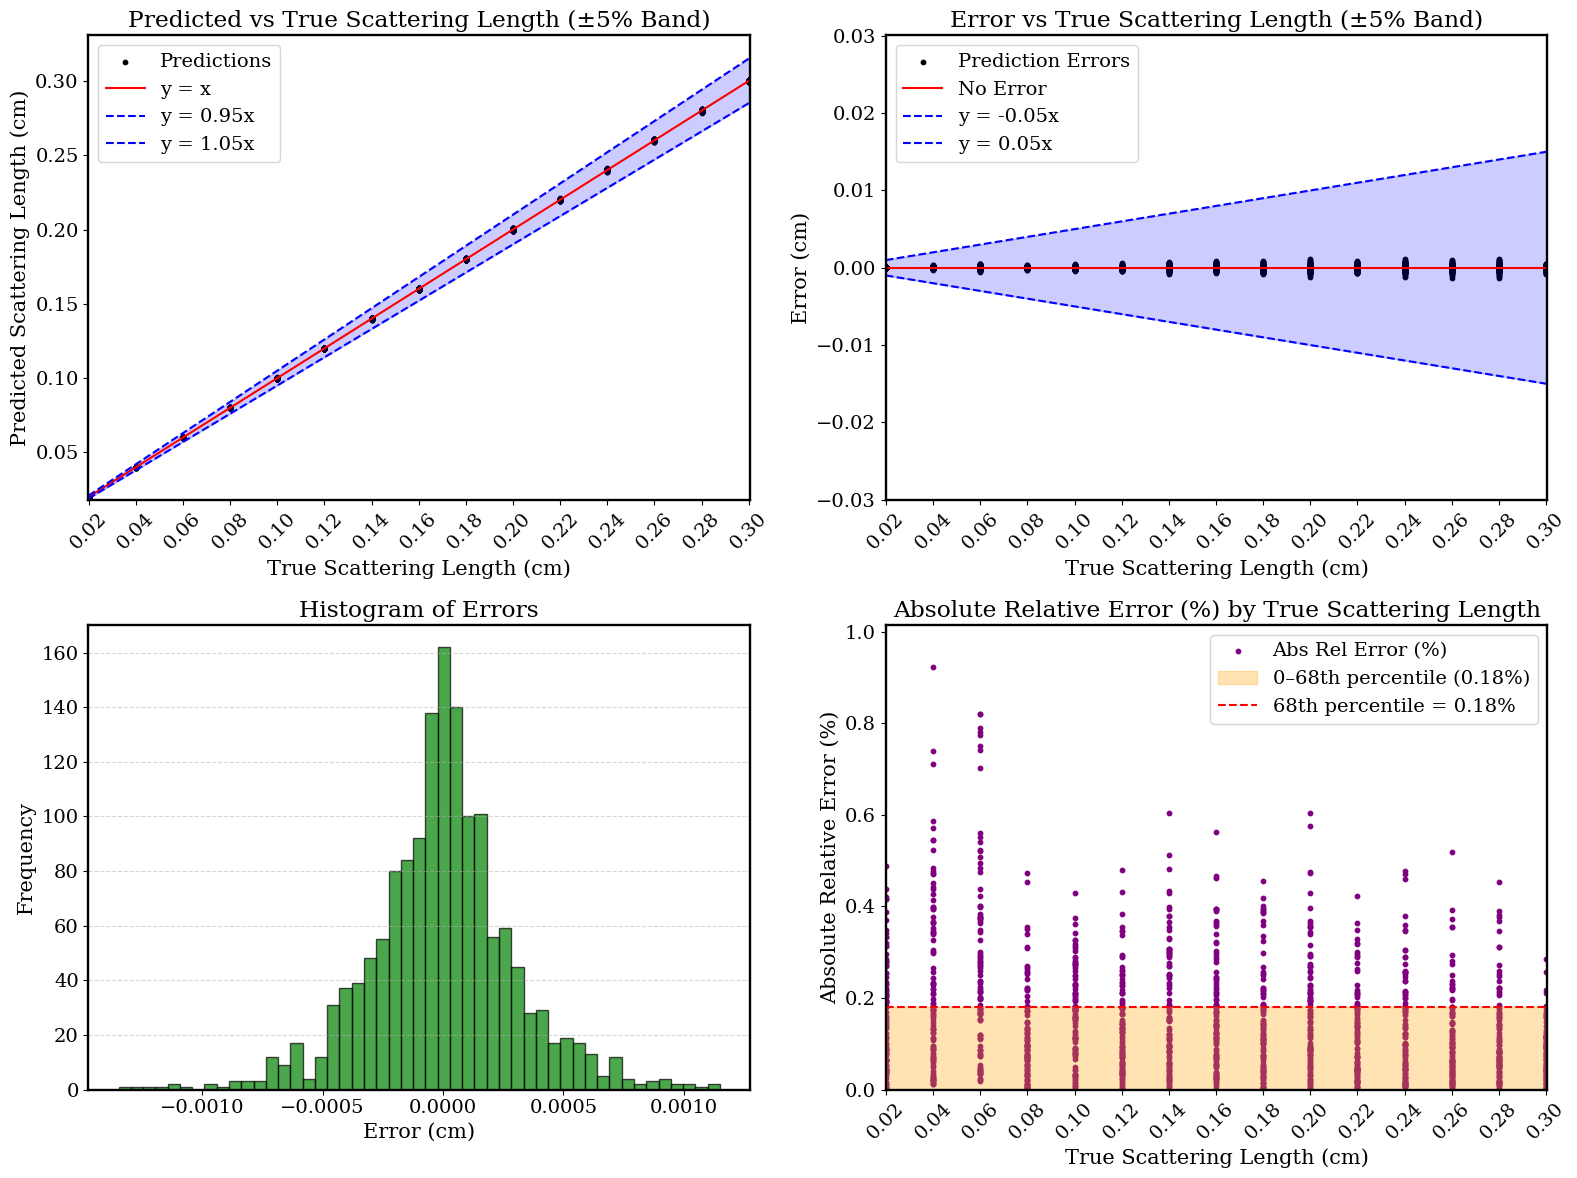

In [26]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0_2_w_5.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=5e-7, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    print(f"\n[Epoch {epoch}/{total_epochs}]")
    
    model.train()
    running_train_loss = 0.0
    total_train_samples = 0
    total_high_weight = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        HIGH_WEIGHT = 1.5
        LOW_WEIGHT = 1.0
        
        # label을 기준으로 가중치 생성
        weights = torch.where(labels > 1.5, HIGH_WEIGHT, LOW_WEIGHT)
        total_high_weight += (weights == HIGH_WEIGHT).sum().item()
        batch_size = images.size(0)
        total_train_samples += batch_size
        
        optimizer.zero_grad()
        outputs = model(images)

        # 가중치 적용된 loss
        loss = (criterion(outputs, labels) * weights).mean()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * batch_size

    train_loss = running_train_loss / total_train_samples if total_train_samples > 0 else float('inf')
    high_ratio = (total_high_weight / (total_train_samples * labels.numel() // batch_size)) * 100  # 비율(%) 계산

    print(f"Train Loss: {train_loss:.6f} | High-weight samples: {total_high_weight}/{total_train_samples * labels.numel() // batch_size} ({high_ratio:.2f}%)")

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → ✅ Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        print(f"  → ❌ No improvement. Wait = {wait}/{patience}")
        if wait >= patience:
            print(f"  → 🛑 Early stopping triggered at epoch {epoch}.")
            break



# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('5.pth', '6.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

Loaded only model weights from checkpoint.

[Epoch 1/150]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_248103/1885613542.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

Train Loss: 0.000001 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000006 | LR: 7e-06
  → ✅ Improved val loss. Checkpoint updated at epoch 1.

[Epoch 2/150]
Train Loss: 0.000001 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000006 | LR: 7e-06
  → ✅ Improved val loss. Checkpoint updated at epoch 2.

[Epoch 3/150]
Train Loss: 0.000001 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000007 | LR: 7e-06
  → ❌ No improvement. Wait = 1/10

[Epoch 4/150]
Train Loss: 0.000001 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000006 | LR: 7e-06
  → ❌ No improvement. Wait = 2/10

[Epoch 5/150]
Train Loss: 0.000001 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000006 | LR: 7e-06
  → ❌ No improvement. Wait = 3/10

[Epoch 6/150]
Train Loss: 0.000001 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000005 | LR: 3.5e-06
  → ✅ Improved val loss. Checkpoint updated at epoch 6.

[Epoch 7/150]
Train Loss: 0.000001 | High-weight samples: 0/12000 (0.00%)
Val Loss: 0.000005 | LR: 3.5e-06

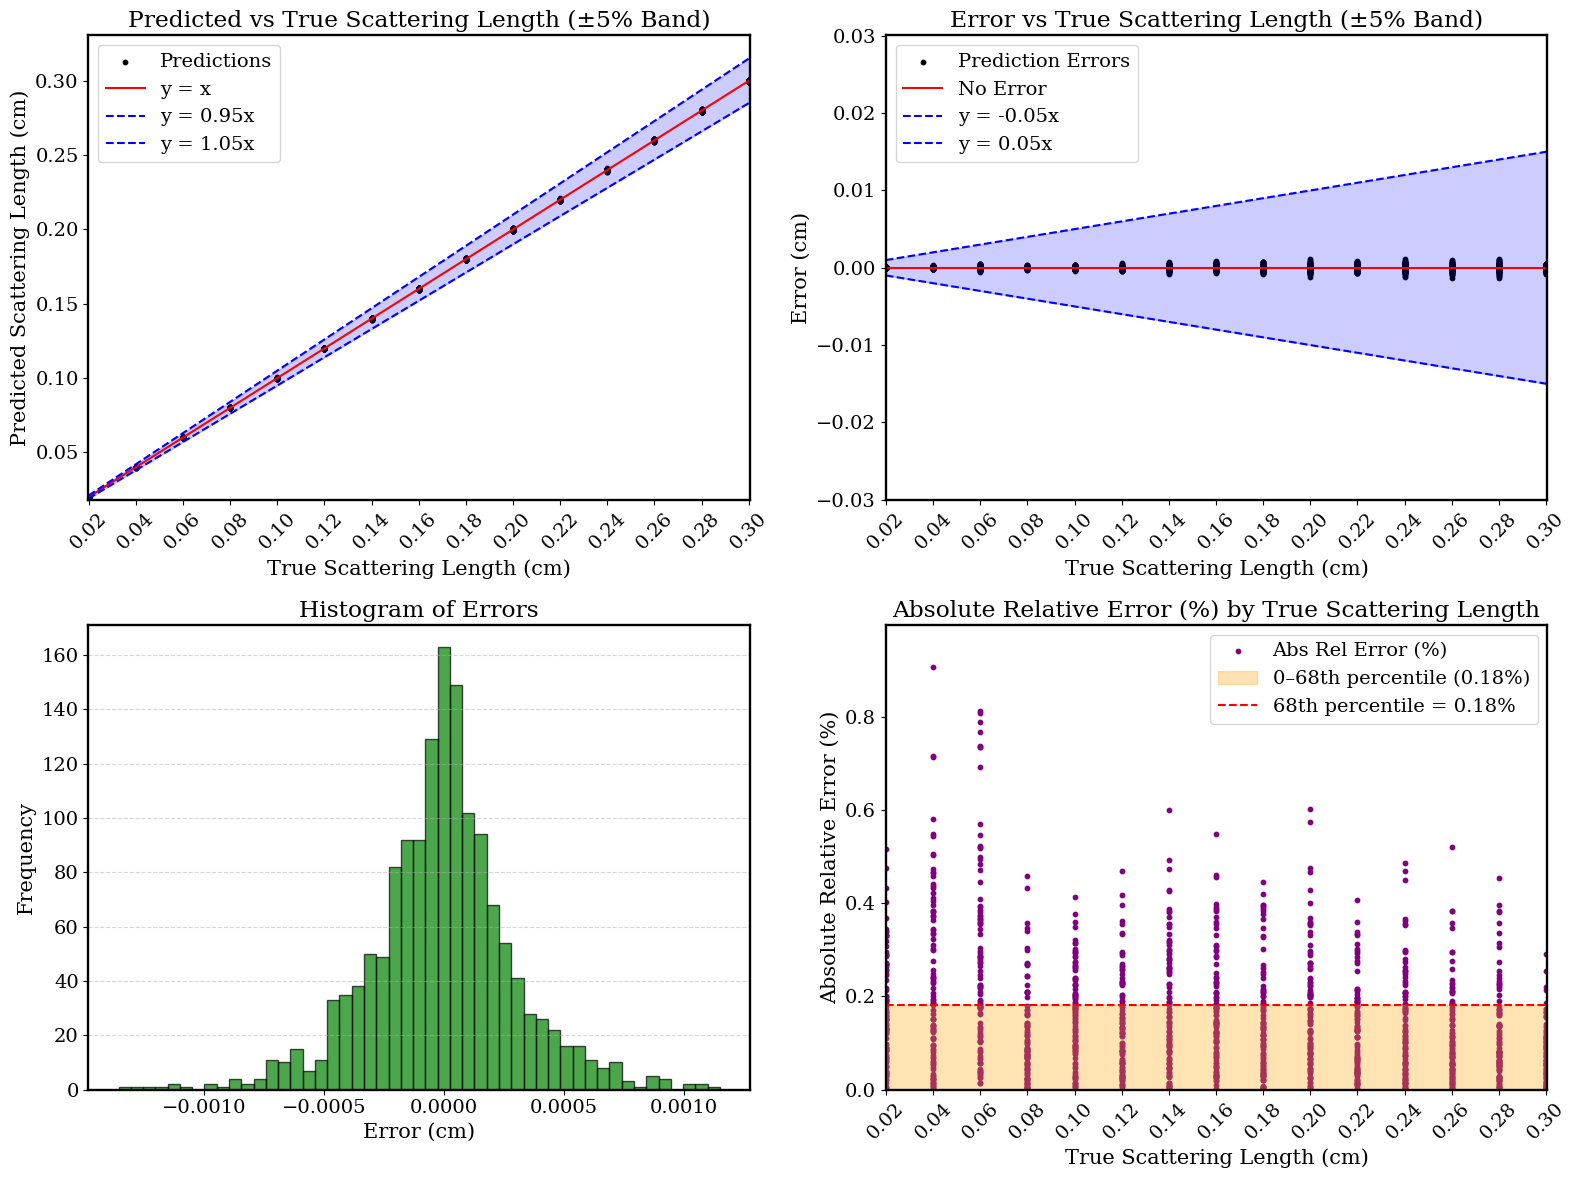

In [37]:
# 1. 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT50_3block(
    img_size=500, patch_size=50, embed_dim=256, depth=3,
    num_heads=8, mlp_dim=1024, num_classes=1
).to(device)

# 2. 오직 model 파라미터만 불러오기
best_model_path = './copy_7_0_0_2_w_6.pth'
checkpoint = torch.load(best_model_path, map_location=device)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded only model weights from checkpoint.")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model weights (state_dict only).")
# (이전 optimizer, scheduler는 무시함)
# 3. 새로운 optimizer, scheduler 정의
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=7e-6, weight_decay=0.01)

# 새로운 스케줄러 예시 1) ReduceLROnPlateau (새로 세팅)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=0.0,
    threshold_mode='abs',
    verbose=True
)

# 또는, 예시 2) CosineAnnealingLR 사용 시
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

criterion = nn.MSELoss()
start_epoch = 1
best_val_loss = float('inf')
additional_epochs = 150
total_epochs = start_epoch + additional_epochs - 1
patience = 10
wait = 0

# 4. (이후 학습 루프는 동일)
for epoch in range(start_epoch, total_epochs + 1):
    print(f"\n[Epoch {epoch}/{total_epochs}]")
    
    model.train()
    running_train_loss = 0.0
    total_train_samples = 0
    total_high_weight = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        HIGH_WEIGHT = 2.8
        LOW_WEIGHT = 1.0
        
        # label을 기준으로 가중치 생성
        weights = torch.where(labels > 1.5, HIGH_WEIGHT, LOW_WEIGHT)
        total_high_weight += (weights == HIGH_WEIGHT).sum().item()
        batch_size = images.size(0)
        total_train_samples += batch_size
        
        optimizer.zero_grad()
        outputs = model(images)

        # 가중치 적용된 loss
        loss = (criterion(outputs, labels) * weights).mean()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * batch_size

    train_loss = running_train_loss / total_train_samples if total_train_samples > 0 else float('inf')
    high_ratio = (total_high_weight / (total_train_samples * labels.numel() // batch_size)) * 100  # 비율(%) 계산

    print(f"Train Loss: {train_loss:.6f} | High-weight samples: {total_high_weight}/{total_train_samples * labels.numel() // batch_size} ({high_ratio:.2f}%)")

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Val Loss: {val_loss:.6f} | LR: {current_lr:.6g}")

    # 스케줄러 업데이트
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # Early Stopping 및 체크포인트
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, best_model_path)
        print(f"  → ✅ Improved val loss. Checkpoint updated at epoch {epoch}.")
    else:
        wait += 1
        print(f"  → ❌ No improvement. Wait = {wait}/{patience}")
        if wait >= patience:
            print(f"  → 🛑 Early stopping triggered at epoch {epoch}.")
            break



# (학습 루프 종료 후 아래 코드 추가)
final_save_path = best_model_path.replace('6.pth', '7.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss
}, final_save_path)
print(f"Final model (last epoch) saved to: {final_save_path}")

model.eval()

true_vals = []
pred_vals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)   # (B, 1, 500, 500)
        labels = labels.to(device)   # (B,)
        outputs = model(images)      # (B,)

        # 정규화 복원 → 원래 스케일로
        labels_orig = ((labels.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min
        preds_orig  = ((outputs.cpu().numpy() + 1.0) / 2.0) * (lbl_max - lbl_min) + lbl_min

        true_vals.extend(labels_orig.tolist())
        pred_vals.extend(preds_orig.tolist())

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)
errors = pred_vals - true_vals
abs_rel_errors = np.abs(errors / true_vals) * 100.0

# (G) 결과 시각화
plt.figure(figsize=(16, 12))
mn = min(true_vals.min(), pred_vals.min())
mx = max(true_vals.max(), pred_vals.max())
unique_true_labels = np.unique(true_vals)

# 1) Predicted vs True with ±5% Band
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(true_vals, pred_vals, s=10, color='black', label='Predictions')
ax1.plot([mn, mx], [mn, mx], color='red', label='y = x')
ax1.plot([mn, mx], [0.95*mn, 0.95*mx], '--', color='blue', label='y = 0.95x')
ax1.plot([mn, mx], [1.05*mn, 1.05*mx], '--', color='blue', label='y = 1.05x')
ax1.fill_between([mn, mx], [0.95*mn, 0.95*mx], [1.05*mn, 1.05*mx], color='blue', alpha=0.2)
ax1.set_xticks(unique_true_labels)
ax1.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax1.set_title("Predicted vs True Scattering Length (±5% Band)")
ax1.set_xlabel("True Scattering Length (cm)")
ax1.set_ylabel("Predicted Scattering Length (cm)")
ax1.set_xlim(mn, mx)
ax1.set_ylim(mn * 0.9, mx * 1.1)
ax1.legend()

# 2) Error vs True with ±5% Band
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(true_vals, errors, s=10, color='black', label='Prediction Errors')
ax2.plot([mn, mx], [0, 0], '-', color='red', label='No Error')
ax2.plot([mn, mx], [-0.05*mn, -0.05*mx], '--', color='blue', label='y = -0.05x')
ax2.plot([mn, mx], [0.05*mn, 0.05*mx], '--', color='blue', label='y = 0.05x')
ax2.fill_between([mn, mx], [-0.05*mn, -0.05*mx], [0.05*mn, 0.05*mx], color='blue', alpha=0.2)
ax2.set_xticks(unique_true_labels)
ax2.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax2.set_title("Error vs True Scattering Length (±5% Band)")
ax2.set_xlabel("True Scattering Length (cm)")
ax2.set_ylabel("Error (cm)")
ax2.set_xlim(mn, mx)
ax2.set_ylim(-0.1 * mx, 0.1 * mx)
ax2.legend()

# 3) Histogram of Errors (50 bins)
ax3 = plt.subplot(2, 2, 3)
bins = np.linspace(errors.min(), errors.max(), 50)
ax3.hist(errors, bins=bins, color='green', alpha=0.7, edgecolor='black')
ax3.set_title("Histogram of Errors")
ax3.set_xlabel("Error (cm)")
ax3.set_ylabel("Frequency")
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# 4) Absolute Relative Error (%) by True with 68th Percentile
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(true_vals, abs_rel_errors, s=10, color='purple', label='Abs Rel Error (%)')
perc68 = np.percentile(abs_rel_errors, 68)
ax4.fill_between([mn, mx], 0, perc68, color='orange', alpha=0.3,
                    label=f'0–68th percentile ({perc68:.2f}%)')
ax4.hlines(perc68, mn, mx, colors='red', linestyles='--',
            label=f'68th percentile = {perc68:.2f}%')
ax4.set_xticks(unique_true_labels)
ax4.set_xticklabels([f"{val:.2f}" for val in unique_true_labels], rotation=45)
ax4.set_title("Absolute Relative Error (%) by True Scattering Length")
ax4.set_xlabel("True Scattering Length (cm)")
ax4.set_ylabel("Absolute Relative Error (%)")
ax4.set_xlim(mn, mx)
ax4.set_ylim(0, max(abs_rel_errors) * 1.1)
ax4.legend()

plt.tight_layout()
plt.show()

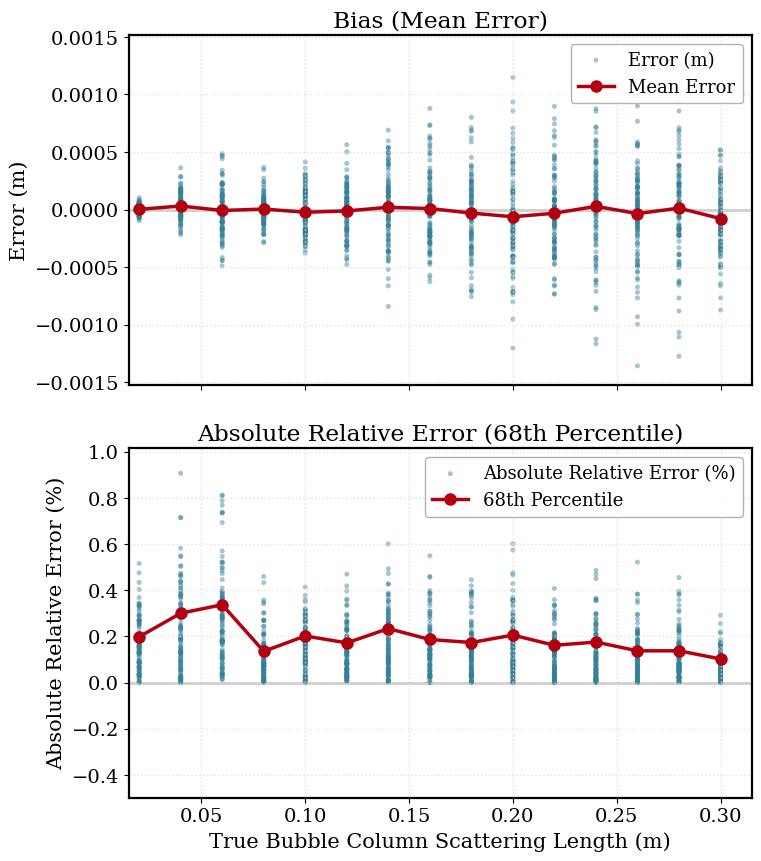

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# ──────────────────────────────
# true_vals, pred_vals, errors, abs_rel_errors 준비
# 예시: (아래 줄은 실제 분석에서 본인 데이터로 대체!)
# true_vals = ...
# pred_vals = ...
# errors = pred_vals - true_vals
# abs_rel_errors = np.abs((pred_vals - true_vals) / true_vals) * 100  # % 단위
# ──────────────────────────────

x_ticks = np.arange(0.02, 0.32, 0.02)  # x축: True Scattering Length (m) 등

def binned_stat(true_vals, stat_vals, bins, stat_func=np.mean):
    """bins 위치별 stat_vals의 대표값(예: 평균, mean 등) 계산"""
    result = []
    for xt in bins:
        mask = np.isclose(true_vals, xt, atol=1e-6)
        if np.any(mask):
            result.append(stat_func(stat_vals[mask]))
        else:
            result.append(np.nan)
    return np.array(result)

def binned_percentile(true_vals, stat_vals, bins, q):
    """bins 위치별 stat_vals의 q-퍼센타일(예: 68%) 계산"""
    result = []
    for xt in bins:
        mask = np.isclose(true_vals, xt, atol=1e-6)
        if np.any(mask):
            result.append(np.percentile(stat_vals[mask], q))
        else:
            result.append(np.nan)
    return np.array(result)

def draw_bias_absrel_subplot(
    true_vals, errors, abs_rel_errors, x_ticks, x_label, figsize=(8, 9)):
    plt.rcParams.update({
        "font.family": "DejaVu Serif",
        "font.size": 14,
        "axes.labelsize": 15,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "axes.linewidth": 1.7,
        "xtick.direction": "out",
        "ytick.direction": "out",
    })

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    dot_color = '#338099'
    line_color = '#B20010'
    # ───── 1. Bias (Mean Error) 플롯 ─────
    bias_means = binned_stat(true_vals, errors, x_ticks, stat_func=np.mean)
    ax = axes[0]
    ax.scatter(
        true_vals, errors, color=dot_color, s=13, alpha=0.45, edgecolors='none',
        rasterized=True, label="Error (m)"
    )
    ax.plot(
        x_ticks, bias_means, color=line_color, lw=2.5, marker='o', markersize=8,
        label="Mean Error"
    )
    ax.axhline(0, color='gray', linestyle='-', linewidth=2.0, zorder=0, alpha=0.4)
    y_max = np.nanmax(np.abs(errors))
    y_pad = 0.12 * y_max
    ax.set_ylim(-y_max - y_pad, y_max + y_pad)
    ax.set_ylabel("Error (m)")
    ax.set_xlim(x_ticks[0] - 0.005, x_ticks[-1] + 0.015)
    ax.legend(fontsize=13, loc='upper right', frameon=True, fancybox=True, framealpha=0.90, edgecolor='#AAA')
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)
    ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
    ax.set_title("Bias (Mean Error)")

    # ───── 2. Absolute Relative Error (%) 플롯 ─────
    p68_vals = binned_percentile(true_vals, abs_rel_errors, x_ticks, 68)
    ax = axes[1]
    ax.scatter(
        true_vals, abs_rel_errors, color=dot_color, s=13, alpha=0.45, edgecolors='none',
        rasterized=True, label="Absolute Relative Error (%)"
    )
    ax.plot(
        x_ticks, p68_vals, color=line_color, lw=2.5, marker='o', markersize=8,
        label="68th Percentile"
    )
    ax.axhline(0, color='gray', linestyle='-', linewidth=2.0, zorder=0, alpha=0.4)
    y_max = np.nanmax(abs_rel_errors)
    y_pad = 0.12 * y_max
    ax.set_ylim(-0.5, y_max + y_pad)   # <- 여기서 y축 -0.5부터 시작!
    ax.set_xlabel(x_label)
    ax.set_ylabel("Absolute Relative Error (%)")
    ax.set_xlim(x_ticks[0] - 0.005, x_ticks[-1] + 0.015)
    ax.legend(fontsize=13, loc='upper right', frameon=True, fancybox=True, framealpha=0.90, edgecolor='#AAA')
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)
    ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
    ax.set_title("Absolute Relative Error (68th Percentile)")

    plt.tight_layout(pad=1.5)
    plt.show()

# ──────────────────────────────────────────────
# 예시 실행
draw_bias_absrel_subplot(
    true_vals, errors, abs_rel_errors,
    x_ticks=x_ticks, x_label="True Bubble Column Scattering Length (m)"
)

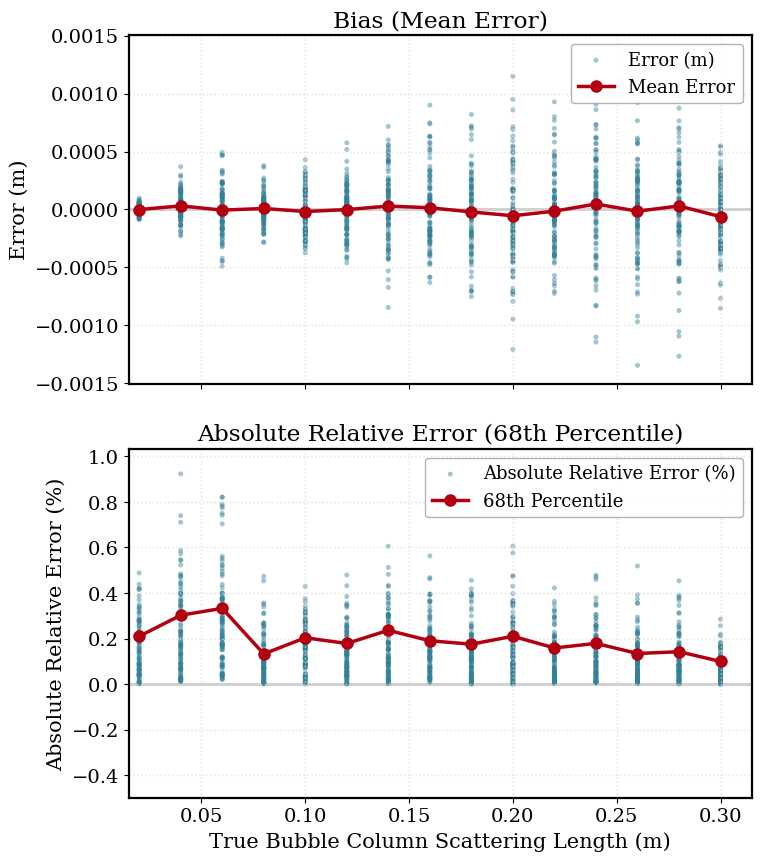

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# ──────────────────────────────
# true_vals, pred_vals, errors, abs_rel_errors 준비
# 예시: (아래 줄은 실제 분석에서 본인 데이터로 대체!)
# true_vals = ...
# pred_vals = ...
# errors = pred_vals - true_vals
# abs_rel_errors = np.abs((pred_vals - true_vals) / true_vals) * 100  # % 단위
# ──────────────────────────────

x_ticks = np.arange(0.02, 0.32, 0.02)  # x축: True Scattering Length (m) 등

def binned_stat(true_vals, stat_vals, bins, stat_func=np.mean):
    """bins 위치별 stat_vals의 대표값(예: 평균, mean 등) 계산"""
    result = []
    for xt in bins:
        mask = np.isclose(true_vals, xt, atol=1e-6)
        if np.any(mask):
            result.append(stat_func(stat_vals[mask]))
        else:
            result.append(np.nan)
    return np.array(result)

def binned_percentile(true_vals, stat_vals, bins, q):
    """bins 위치별 stat_vals의 q-퍼센타일(예: 68%) 계산"""
    result = []
    for xt in bins:
        mask = np.isclose(true_vals, xt, atol=1e-6)
        if np.any(mask):
            result.append(np.percentile(stat_vals[mask], q))
        else:
            result.append(np.nan)
    return np.array(result)

def draw_bias_absrel_subplot(
    true_vals, errors, abs_rel_errors, x_ticks, x_label, figsize=(8, 9)):
    plt.rcParams.update({
        "font.family": "DejaVu Serif",
        "font.size": 14,
        "axes.labelsize": 15,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "axes.linewidth": 1.7,
        "xtick.direction": "out",
        "ytick.direction": "out",
    })

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    dot_color = '#338099'
    line_color = '#B20010'
    # ───── 1. Bias (Mean Error) 플롯 ─────
    bias_means = binned_stat(true_vals, errors, x_ticks, stat_func=np.mean)
    ax = axes[0]
    ax.scatter(
        true_vals, errors, color=dot_color, s=13, alpha=0.45, edgecolors='none',
        rasterized=True, label="Error (m)"
    )
    ax.plot(
        x_ticks, bias_means, color=line_color, lw=2.5, marker='o', markersize=8,
        label="Mean Error"
    )
    ax.axhline(0, color='gray', linestyle='-', linewidth=2.0, zorder=0, alpha=0.4)
    y_max = np.nanmax(np.abs(errors))
    y_pad = 0.12 * y_max
    ax.set_ylim(-y_max - y_pad, y_max + y_pad)
    ax.set_ylabel("Error (m)")
    ax.set_xlim(x_ticks[0] - 0.005, x_ticks[-1] + 0.015)
    ax.legend(fontsize=13, loc='upper right', frameon=True, fancybox=True, framealpha=0.90, edgecolor='#AAA')
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)
    ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
    ax.set_title("Bias (Mean Error)")

    # ───── 2. Absolute Relative Error (%) 플롯 ─────
    p68_vals = binned_percentile(true_vals, abs_rel_errors, x_ticks, 68)
    ax = axes[1]
    ax.scatter(
        true_vals, abs_rel_errors, color=dot_color, s=13, alpha=0.45, edgecolors='none',
        rasterized=True, label="Absolute Relative Error (%)"
    )
    ax.plot(
        x_ticks, p68_vals, color=line_color, lw=2.5, marker='o', markersize=8,
        label="68th Percentile"
    )
    ax.axhline(0, color='gray', linestyle='-', linewidth=2.0, zorder=0, alpha=0.4)
    y_max = np.nanmax(abs_rel_errors)
    y_pad = 0.12 * y_max
    ax.set_ylim(-0.5, y_max + y_pad)   # <- 여기서 y축 -0.5부터 시작!
    ax.set_xlabel(x_label)
    ax.set_ylabel("Absolute Relative Error (%)")
    ax.set_xlim(x_ticks[0] - 0.005, x_ticks[-1] + 0.015)
    ax.legend(fontsize=13, loc='upper right', frameon=True, fancybox=True, framealpha=0.90, edgecolor='#AAA')
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)
    ax.grid(True, which='both', linestyle=':', linewidth=1.05, color='#DDDDDD', alpha=0.8)
    ax.set_title("Absolute Relative Error (68th Percentile)")

    plt.tight_layout(pad=1.5)
    plt.show()

# ──────────────────────────────────────────────
# 예시 실행
draw_bias_absrel_subplot(
    true_vals, errors, abs_rel_errors,
    x_ticks=x_ticks, x_label="True Bubble Column Scattering Length (m)"
)

In [39]:
import json
import numpy as np

# true_vals, errors, abs_rel_errors가 이미 numpy array로 있다고 가정 (단위: m, %, 모두 1D)

data_points = [
    {
        "x": float(true_vals[i] * 100),      # cm 단위
        "error": float(errors[i] * 100),     # cm 단위
        "rel_error": float(abs_rel_errors[i])  # %
    }
    for i in range(len(true_vals))
]

# JSON string으로 출력
json_str = json.dumps(data_points, indent=2)
print(json_str)

# (선택) 파일로 저장
with open("/home/work/CamSim/Hole_Output/s3_seed/best_final.json", "w") as f:
    json.dump(data_points, f, indent=2)

[
  {
    "x": 1.9999999552965164,
    "error": 0.008672662079334259,
    "rel_error": 0.4336331136591683
  },
  {
    "x": 1.9999999552965164,
    "error": 0.0028522685170173645,
    "rel_error": 0.14261342903852675
  },
  {
    "x": 1.9999999552965164,
    "error": -0.005904585123062134,
    "rel_error": 0.2952292627519949
  },
  {
    "x": 1.9999999552965164,
    "error": -0.005116872489452362,
    "rel_error": 0.25584363019116885
  },
  {
    "x": 1.9999999552965164,
    "error": -0.003851950168609619,
    "rel_error": 0.19259751273537082
  },
  {
    "x": 1.9999999552965164,
    "error": -0.0030273571610450745,
    "rel_error": 0.15136786143558906
  },
  {
    "x": 1.9999999552965164,
    "error": -0.0033345073461532593,
    "rel_error": 0.1667253710342654
  },
  {
    "x": 1.9999999552965164,
    "error": -0.0017156824469566345,
    "rel_error": 0.08578412426525632
  },
  {
    "x": 1.9999999552965164,
    "error": 0.005832873284816742,
    "rel_error": 0.2916436707595811
  },
  

In [33]:
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 가정: abs_rel_errors 라는 numpy array가 이미 준비되어 있습니다.
#      (shape = (N,), 각 샘플의 Absolute Relative Error (%))
# ─────────────────────────────────────────────────────────────────────────────

# Mean Absolute Relative Error
mean_abs_rel_error = np.mean(abs_rel_errors)

# Overall 68th Percentile
overall_p68 = np.percentile(abs_rel_errors, 68)

print(f"Mean Absolute Relative Error: {mean_abs_rel_error:.3f}%")
print(f"Overall 68th Percentile: {overall_p68:.3f}%")


Mean Absolute Relative Error: 0.155%
Overall 68th Percentile: 0.181%


In [16]:
import numpy as np
import pandas as pd

# pred_vals, true_vals: (N,) numpy array (이미 준비되어 있다고 가정)
# unique_labels: np.unique(true_vals) (라벨 후보, float/정수 상관없음)

results = []
for lbl in unique_true_labels:
    idx = np.where(true_vals == lbl)[0]
    errs = pred_vals[idx] - true_vals[idx]
    rel_errs = np.abs(errs / true_vals[idx]) * 100

    mean_err = np.mean(errs)
    mean_rel_err = np.mean(rel_errs)
    # 90% range: 5th–95th percentile (central 90%)
    range90_err = np.percentile(errs, [5, 95])
    range90_rel_err = np.percentile(rel_errs, [5, 95])
    range90_err_val = f"±{(range90_err[1]-range90_err[0])/2:.3f}"
    range90_rel_err_val = f"{(range90_rel_err[1]-range90_rel_err[0]):.3f}"

    results.append({
        "Scattering Length (cm)": lbl,
        "Mean Error (cm)": f"{mean_err:.3f}",
        "Mean Relative Error (%)": f"{mean_rel_err:.3f}",
        "90% Range of Error (cm)": range90_err_val,
        "90% Range of Relative Error (%)": range90_rel_err_val,
    })

# 전체(총계)도 계산
errs = pred_vals - true_vals
rel_errs = np.abs(errs / true_vals) * 100
mean_err = np.mean(errs)
mean_rel_err = np.mean(rel_errs)
range90_err = np.percentile(errs, [5, 95])
range90_rel_err = np.percentile(rel_errs, [5, 95])
range90_err_val = f"±{(range90_err[1]-range90_err[0])/2:.3f}"
range90_rel_err_val = f"{(range90_rel_err[1]-range90_rel_err[0]):.3f}"

results.append({
    "Scattering Length (cm)": "Total",
    "Mean Error (cm)": f"{mean_err:.3f}",
    "Mean Relative Error (%)": f"{mean_rel_err:.3f}",
    "90% Range of Error (cm)": range90_err_val,
    "90% Range of Relative Error (%)": range90_rel_err_val,
})

df = pd.DataFrame(results)
print(df)

   Scattering Length (cm) Mean Error (cm) Mean Relative Error (%)  \
0                    0.02           0.000                   0.185   
1                    0.04           0.000                   0.250   
2                    0.06          -0.000                   0.291   
3                    0.08           0.000                   0.130   
4                     0.1          -0.000                   0.173   
5                    0.12           0.000                   0.145   
6                    0.14           0.000                   0.183   
7                    0.16           0.000                   0.177   
8                    0.18          -0.000                   0.153   
9                     0.2          -0.000                   0.179   
10                   0.22          -0.000                   0.125   
11                   0.24           0.000                   0.137   
12                   0.26          -0.000                   0.113   
13                   0.28         